In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
# import imageio
from PIL import Image

In [2]:
def load_images_from_folder(folder):
    images = []
    y = []
#     d = {0:0,2:1, 3:2, 7:3, 8:4}
    for i in folder:
        for filename in os.listdir(i):
#             print(filename)
            img = Image.open(os.path.join(i,filename))
            if img is not None:
                images.append(np.asarray(img))
            # print(int(i[-1]), end="")
            y.append(int(i[-1]))
    images = np.array(images)
    y = np.array(y)
    x_data , y_data = shuffle(images, y)
    return x_data, y_data

In [3]:
train_data, y_train = load_images_from_folder(["./Group_14/train/0", "./Group_14/train/2", "./Group_14/train/3", "./Group_14/train/7", "./Group_14/train/8"])
test_data, y_test = load_images_from_folder(["./Group_14/test/0", "./Group_14/test/2", "./Group_14/test/3", "./Group_14/test/7", "./Group_14/test/8"])
val_data, y_val = load_images_from_folder(["./Group_14/val/0", "./Group_14/val/2", "./Group_14/val/3", "./Group_14/val/7", "./Group_14/val/8"])
train_data = train_data/255
val_data = val_data/255
test_data = test_data/255

In [4]:

def MSE(pred, actual):
    pred = pred.reshape(len(pred), 28*28)
    actual = actual.reshape(len(actual), 28*28)
    # print(pred[0])
    # print(actual[0])
    mse = 0
    for i in range(len(pred)):
        t = np.square(pred[i]-actual[i])
        mse += np.sum(t,axis=0)
    return mse/len(pred)


In [5]:

from autoencoder import Autoencoder


class ModelCallBack(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.avg_error = []
        self.prev_error = 0
        self.current_error = 0
        self.end_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        # print(logs)
        if epoch == 0:
            self.prev_error = logs["mean_squared_error"]
            self.current_error = logs["mean_squared_error"]
        else:
            self.current_error = logs["mean_squared_error"]
            if abs(self.current_error-self.prev_error)<1e-4:
                # self.end_epoch = epoch
                self.model.stop_training = True
            else:
                self.prev_error = self.current_error
        # print(logs["sparse_categorical_crossentropy"])
        print("Epoch", epoch, "done | MSE:", logs["mean_squared_error"])
        self.end_epoch = epoch
        self.avg_error.append(self.prev_error)

In [6]:
best_arch = {}

In [10]:



def run_q2(AE_arch):

    train_RE = []
    val_RE = []
    val_best_arch = 1000
    
    for i in range(len(AE_arch)):
        print("-"*25+"Training Autoencoder with Architecture:"+str(AE_arch[i])+"-"*25)
        model_callback = ModelCallBack()
        AE = Autoencoder(AE_arch[i])
        AE.compile(optimizer='adam', loss="mean_squared_error", metrics=['mean_squared_error'])

        AE.fit(np.array(train_data), 
               np.array(train_data), 
               epochs = 1000, 
               shuffle=True, 
               verbose=0,
               callbacks=[model_callback])

        AE.avg_error = model_callback.avg_error
        AE.end_epoch = model_callback.end_epoch

        train_pred = AE.predict(train_data)
        val_pred = AE.predict(val_data)

        train_RE.append(MSE(train_pred, train_data))
        print("Training Reconstruction Error:", train_RE[-1])
        val_RE.append(MSE(val_pred, val_data))
        print("Validation Reconstruction Error:", val_RE[-1])
        if val_RE[-1]<val_best_arch :
            best_arch["Hidden Layer {}".format(len(AE_arch[0]))] = AE
            val_best_arch = val_RE[-1]
        print()

    data = {}
    for j in range(len(AE_arch[0])):
        data["Layer {} Neurons".format(j+1)] = AE_arch[:,j]  

    data["Training Reconstruction Error"] = train_RE 
    data["Validation Reconstruction Error"] = val_RE
    df = pd.DataFrame(data)
    display(df)

In [11]:
AE_h1 = np.array([[128], [64], [100]])  # Different Autoencoder with One Hidden Layer 
AE_h3 = np.array([[128,64,128], [512,128,512], [200,100,200]]) # Different Autoencoder with Three Hidden Layer

In [12]:
run_q2(AE_h1)

-------------------------Training Autoencoder with Architecture:[128]-------------------------
Epoch 0 done | MSE: 0.06436661630868912
Epoch 1 done | MSE: 0.040926478803157806
Epoch 2 done | MSE: 0.03163072466850281
Epoch 3 done | MSE: 0.025698959827423096
Epoch 4 done | MSE: 0.021493466570973396
Epoch 5 done | MSE: 0.018384987488389015
Epoch 6 done | MSE: 0.016025356948375702
Epoch 7 done | MSE: 0.014206468127667904
Epoch 8 done | MSE: 0.012769101187586784
Epoch 9 done | MSE: 0.011618361808359623
Epoch 10 done | MSE: 0.010690365917980671
Epoch 11 done | MSE: 0.009912095032632351
Epoch 12 done | MSE: 0.009257755242288113
Epoch 13 done | MSE: 0.008688794448971748
Epoch 14 done | MSE: 0.008183212019503117
Epoch 15 done | MSE: 0.0077436561696231365
Epoch 16 done | MSE: 0.0073507074266672134
Epoch 17 done | MSE: 0.007000686135143042
Epoch 18 done | MSE: 0.006667079869657755
Epoch 19 done | MSE: 0.006364349741488695
Epoch 20 done | MSE: 0.0060977390967309475
Epoch 21 done | MSE: 0.005840321

,Layer 1 Neurons,Training Reconstruction Error,Validation Reconstruction Error
0,128,2.553928,3.021354
1,64,4.712975,5.138082
2,100,2.913603,3.366698


In [14]:
run_q2(AE_h3)

-------------------------Training Autoencoder with Architecture:[128  64 128]-------------------------
Epoch 0 done | MSE: 0.07381724566221237
Epoch 1 done | MSE: 0.0620855949819088
Epoch 2 done | MSE: 0.0526764877140522
Epoch 3 done | MSE: 0.04532429575920105
Epoch 4 done | MSE: 0.04160812869668007
Epoch 5 done | MSE: 0.038106922060251236
Epoch 6 done | MSE: 0.035240814089775085
Epoch 7 done | MSE: 0.032410260289907455
Epoch 8 done | MSE: 0.030254872515797615
Epoch 9 done | MSE: 0.028398048132658005
Epoch 10 done | MSE: 0.026951059699058533
Epoch 11 done | MSE: 0.025613771751523018
Epoch 12 done | MSE: 0.024363113567233086
Epoch 13 done | MSE: 0.023288484662771225
Epoch 14 done | MSE: 0.0223989374935627
Epoch 15 done | MSE: 0.02161707729101181
Epoch 16 done | MSE: 0.020885631442070007
Epoch 17 done | MSE: 0.02014053426682949
Epoch 18 done | MSE: 0.01946353353559971
Epoch 19 done | MSE: 0.018831731751561165
Epoch 20 done | MSE: 0.018273497000336647
Epoch 21 done | MSE: 0.01773967407643

,Layer 1 Neurons,Layer 2 Neurons,Layer 3 Neurons,Training Reconstruction Error,Validation Reconstruction Error
0,128,64,128,7.281954,8.095446
1,512,128,512,4.152770,5.265796
2,200,100,200,5.671501,6.575054


In [15]:
best_arch

{'Hidden Layer 1': <autoencoder.Autoencoder at 0x7f0f805a7080>,
 'Hidden Layer 3': <autoencoder.Autoencoder at 0x7f0f5c5bad68>}

In [16]:
best_arch["Hidden Layer 1"].hidden_layers


array([128])

In [17]:
best_arch["Hidden Layer 3"].hidden_layers

array([512, 128, 512])

In [18]:
pred = best_arch["Hidden Layer 1"].predict(test_data) 
print("Test Reconstruction Error of Best Architecture with 1 Hidden Layer:", MSE(pred, test_data))
pred = best_arch["Hidden Layer 3"].predict(test_data) 
print("Test Reconstruction Error of Best Architecture with 3 Hidden Layer:", MSE(pred, test_data))

Test Reconstruction Error of Best Architecture with 1 Hidden Layer: 3.050442793072772
Test Reconstruction Error of Best Architecture with 3 Hidden Layer: 5.364206313180808


In [19]:
def plot_error_vs_epoch(best_arch):
    plt.plot(range(best_arch.end_epoch+1), best_arch.avg_error)
    plt.xlabel("No. of Epochs")
    plt.ylabel("Average Errors")
    plt.title("Average Error Vs Epoch of Autoencoder with \n{} Hidden Layer :{}".format(len(best_arch.hidden_layers), best_arch.hidden_layers))
    plt.show()

--------------------Plot of Avg Error v/s Epoch of Best Architecture with 1 Hidden Layer--------------------


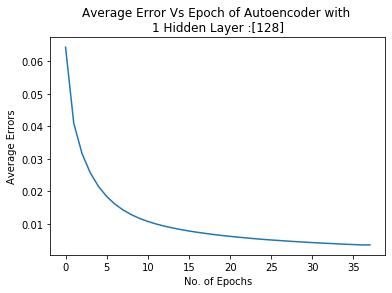

In [20]:
print("-"*20+"Plot of Avg Error v/s Epoch of Best Architecture with 1 Hidden Layer"+"-"*20)
plot_error_vs_epoch(best_arch["Hidden Layer 1"])

--------------------Plot of Avg Error v/s Epoch of Best Architecture with 3 Hidden Layer--------------------


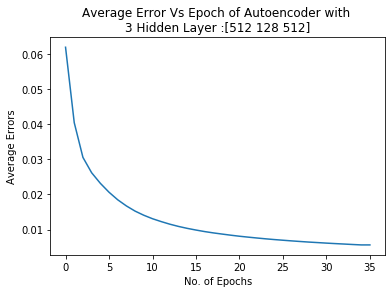

In [21]:
print("-"*20+"Plot of Avg Error v/s Epoch of Best Architecture with 3 Hidden Layer"+"-"*20)
plot_error_vs_epoch(best_arch["Hidden Layer 3"])

In [22]:
import random

def plot_Re_and_orig_images(best_arch, data, n):
     
    randomlist = random.sample(range(len(data)), n)
    encoded_imgs = best_arch.encoder(train_data).numpy()
    decoded_imgs = best_arch.decoder(encoded_imgs).numpy()
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(train_data[randomlist[i]])
        plt.title("original")
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[randomlist[i]])
        plt.title("reconstructed")
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    return randomlist

In [23]:
print(plt.style.available)

['bmh', 'classic', 'seaborn-white', 'seaborn-dark', 'seaborn-paper', '_classic_test', 'ggplot', 'seaborn-talk', 'seaborn-bright', 'dark_background', 'Solarize_Light2', 'seaborn-whitegrid', 'seaborn-muted', 'grayscale', 'seaborn-deep', 'seaborn-notebook', 'seaborn-ticks', 'seaborn-colorblind', 'seaborn-dark-palette', 'fast', 'seaborn-poster', 'fivethirtyeight', 'seaborn-darkgrid', 'seaborn-pastel', 'tableau-colorblind10', 'seaborn']


-----Plot of Original V/s Reconstructed Error for Training Data of Best Architecture with 1 Hidden Layer-----


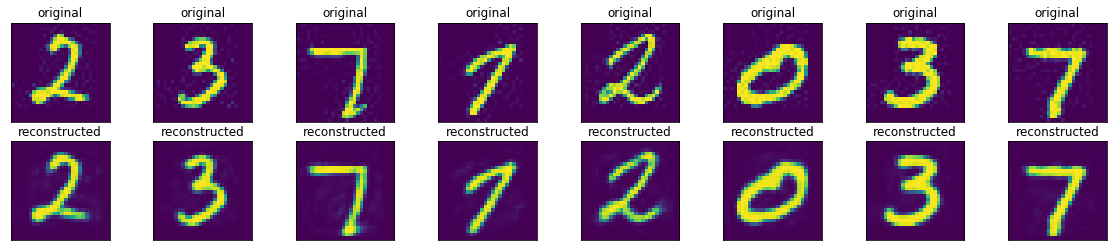

In [24]:
print("-"*5+"Plot of Original V/s Reconstructed Error for Training Data of Best Architecture with 1 Hidden Layer"+"-"*5)
h1_rl_train = plot_Re_and_orig_images(best_arch["Hidden Layer 1"], train_data, 8)

-----Plot of Original V/s Reconstructed Error for validation Data of Best Architecture with 1 Hidden Layer-----


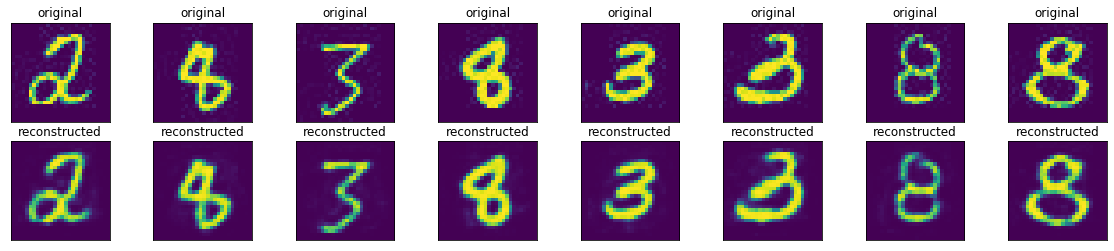

In [25]:
print("-"*5+"Plot of Original V/s Reconstructed Error for validation Data of Best Architecture with 1 Hidden Layer"+"-"*5)
h1_rl_val = plot_Re_and_orig_images(best_arch["Hidden Layer 1"], val_data, 8)

-----Plot of Original V/s Reconstructed Error for Training Data of Best Architecture with 3 Hidden Layer-----


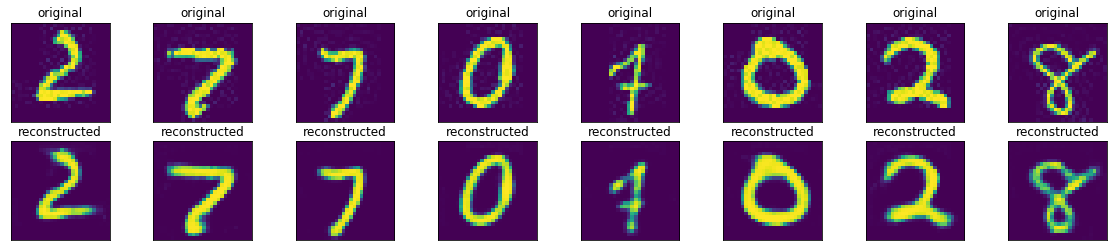

In [26]:
print("-"*5+"Plot of Original V/s Reconstructed Error for Training Data of Best Architecture with 3 Hidden Layer"+"-"*5)
h3_rl_train = plot_Re_and_orig_images(best_arch["Hidden Layer 3"], train_data, 8)

-----Plot of Original V/s Reconstructed Error for Training Data of Best Architecture with 3 Hidden Layer-----


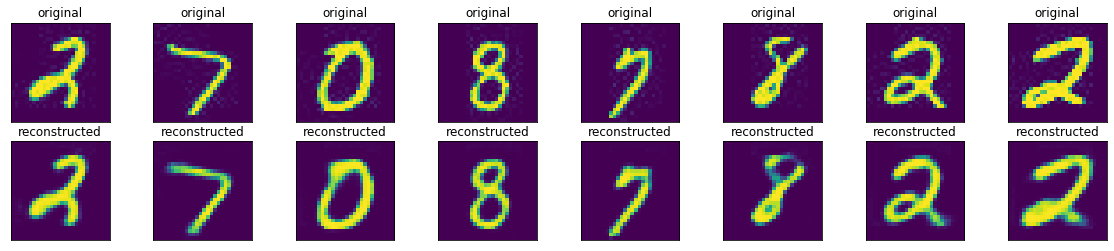

In [27]:
print("-"*5+"Plot of Original V/s Reconstructed Error for Training Data of Best Architecture with 3 Hidden Layer"+"-"*5)
h3_rl_val = plot_Re_and_orig_images(best_arch["Hidden Layer 3"], val_data, 8)

In [28]:

from fcnn import fcnn

def fcnn_on_compressed(best_arch):

    encoded_train_imgs = best_arch.encoder(train_data).numpy()
    encoded_test_imgs = best_arch.encoder(test_data).numpy()
    encoded_val_imgs = best_arch.encoder(val_data).numpy()

    fcnn_arch = [[64], [64,32,16],[128,32]]
    best_arch_layers = best_arch.hidden_layers
    input = best_arch_layers[len(best_arch_layers)//2]
#     print("fcnn Input:", input)
    fcnn_train_acc = []
    fcnn_test_acc = []
    fcnn_val_acc = []
    for arch in fcnn_arch:
        print("-"*25+"FCNN with Architecture: "+str(arch)+"-"*25)
        fcnn_model = fcnn((input,), arch, 5, "adam" ,False)
        fcnn_model._fit_(np.array(encoded_train_imgs), np.array(y_train))
        pred = fcnn_model.prediction(encoded_train_imgs)
        print("Confusion Matrix of Training Data")
        fcnn_model.confusion_matrix(pred, y_train)
        fcnn_train_acc.append(fcnn_model.accuracy(pred, y_train))

        pred = fcnn_model.prediction(encoded_val_imgs)
        print("Confusion Matrix of Validation Data")
        fcnn_model.confusion_matrix(pred, y_val)
        fcnn_val_acc.append(fcnn_model.accuracy(pred, y_val))
        
        pred = fcnn_model.prediction(encoded_test_imgs)
        print("Confusion Matrix of Test Data")
        fcnn_model.confusion_matrix(pred, y_test)
        fcnn_test_acc.append(fcnn_model.accuracy(pred, y_test))

        

    df = pd.DataFrame({
        "FCNN Architecture": fcnn_arch,
        "Training Accuracy": fcnn_train_acc,
        "Test Accuracy": fcnn_test_acc,
        "Validation Accuracy": fcnn_val_acc
    })
    display(df)


----------Classification using the compressed representation from the encoder with 1 Hidden Layers:----------
-------------------------FCNN with Architecture: [64]-------------------------
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 5)                 325       
                                                                 
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.6125586032867432
Epoch 1 done | loss: 0.23887555301189423
Epoch 2 done | loss: 0.1983880251646042
Epoch 3 done | loss: 0.18154221773147583
Epoch 4 done | loss: 0.1715056449174881
Epoch 5 done | loss: 0.1613186001777649
Epoch 6 don

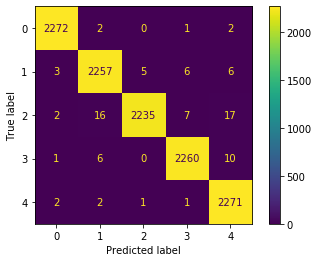

Confusion Matrix of Validation Data


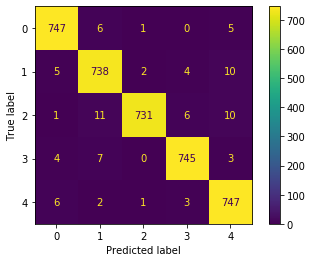

Confusion Matrix of Test Data


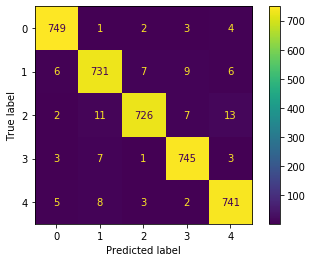

-------------------------FCNN with Architecture: [64, 32, 16]-------------------------
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dense_25 (Dense)            (None, 5)                 85        
                                                                 
Total params: 10,949
Trainable params: 10,949
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.670169472694397
Epoch 1 done | loss: 0.23312894999980927
Epoch 2 d

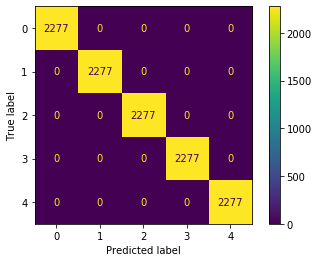

Confusion Matrix of Validation Data


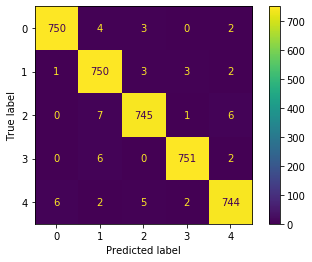

Confusion Matrix of Test Data


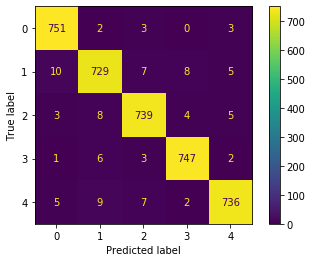

-------------------------FCNN with Architecture: [128, 32]-------------------------
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 32)                4128      
                                                                 
 dense_28 (Dense)            (None, 5)                 165       
                                                                 
Total params: 20,805
Trainable params: 20,805
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.4938544034957886
Epoch 1 done | loss: 0.2048797309398651
Epoch 2 done | loss: 0.17723779380321503
Epoch 3 done | loss: 0.1596655696630478
Epoch 4 done | loss: 0.14073555171489716
Epoch 5 done | loss: 0

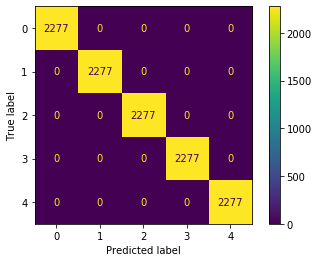

Confusion Matrix of Validation Data


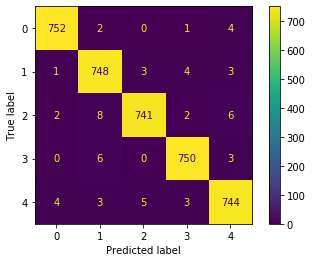

Confusion Matrix of Test Data


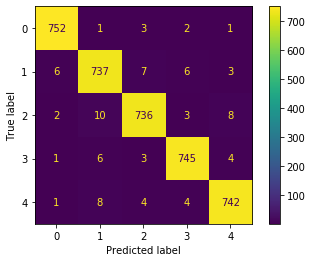

,FCNN Architecture,Training Accuracy,Test Accuracy,Validation Accuracy
0,[64],0.992095,0.972859,0.977075
1,"[64, 32, 16]",1.000000,0.975494,0.985507
2,"[128, 32]",1.000000,0.978129,0.984190


In [29]:
print("-"*10+"Classification using the compressed representation from the encoder with 1 Hidden Layers:"+"-"*10)
fcnn_on_compressed(best_arch["Hidden Layer 1"])

----------Classification using the compressed representation from the encoder with 3 Hidden Layers:----------
-------------------------FCNN with Architecture: [64]-------------------------
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 5)                 325       
                                                                 
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.5300812721252441
Epoch 1 done | loss: 0.2331264168024063
Epoch 2 done | loss: 0.1989155262708664
Epoch 3 done | loss: 0.17941975593566895
Epoch 4 done | loss: 0.16343647241592407
Epoch 5 done | loss: 0.14907880127429962
Epoch 6 do

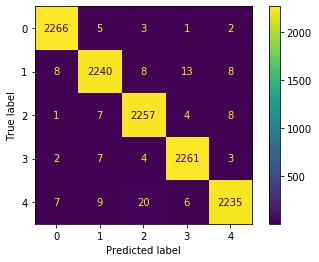

Confusion Matrix of Validation Data


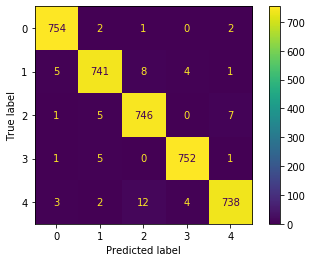

Confusion Matrix of Test Data


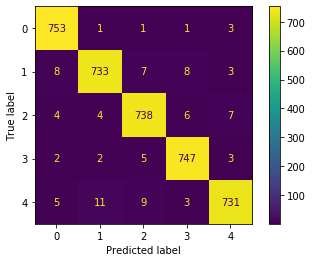

-------------------------FCNN with Architecture: [64, 32, 16]-------------------------
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 16)                528       
                                                                 
 dense_34 (Dense)            (None, 5)                 85        
                                                                 
Total params: 10,949
Trainable params: 10,949
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.4857657849788666
Epoch 1 done | loss: 0.21158437430858612
Epoch 2 

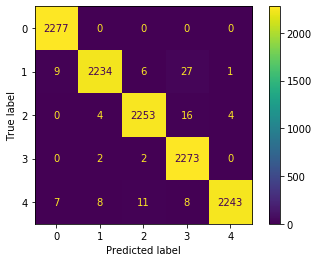

Confusion Matrix of Validation Data


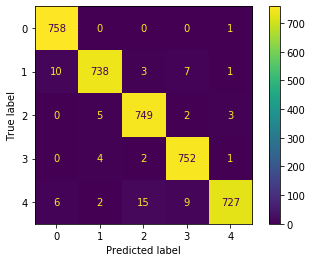

Confusion Matrix of Test Data


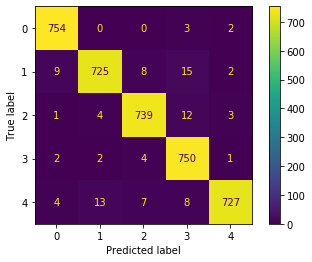

-------------------------FCNN with Architecture: [128, 32]-------------------------
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               16512     
                                                                 
 dense_36 (Dense)            (None, 32)                4128      
                                                                 
 dense_37 (Dense)            (None, 5)                 165       
                                                                 
Total params: 20,805
Trainable params: 20,805
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.4100664556026459
Epoch 1 done | loss: 0.19676853716373444
Epoch 2 done | loss: 0.15118874609470367
Epoch 3 done | loss: 0.12780965864658356
Epoch 4 done | loss: 0.10877563059329987
Epoch 5 done | loss:

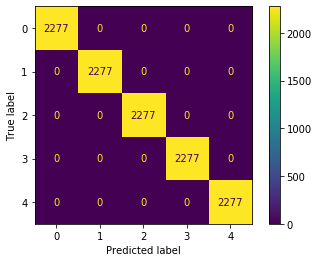

Confusion Matrix of Validation Data


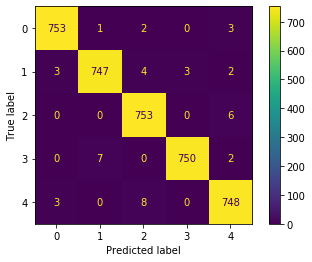

Confusion Matrix of Test Data


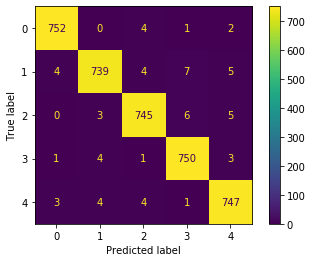

,FCNN Architecture,Training Accuracy,Test Accuracy,Validation Accuracy
0,[64],0.988933,0.975494,0.983136
1,"[64, 32, 16]",0.990777,0.973650,0.981291
2,"[128, 32]",1.000000,0.983663,0.988406


In [30]:
print("-"*10+"Classification using the compressed representation from the encoder with 3 Hidden Layers:"+"-"*10)
fcnn_on_compressed(best_arch["Hidden Layer 3"])

In [31]:
def weight_visualization(best_arch):

    weights = best_arch.layers[0].get_weights()[0]
    print("Weights Shape:",weights.shape)
    weights = weights.T
    i = 0
    k = 0
    
    # t = 0
    for i in range(32):
        plt.figure(figsize=(20, 4))
        j = 4*i
        for k in range(4):
            plt.subplot(1,4,k+1)
            plt.imshow(weights[j+k].reshape((28,28)))
            plt.title("Neuron {}".format(j+k+1))
            # t+=1
        plt.show()

Weights Shape: (784, 128)


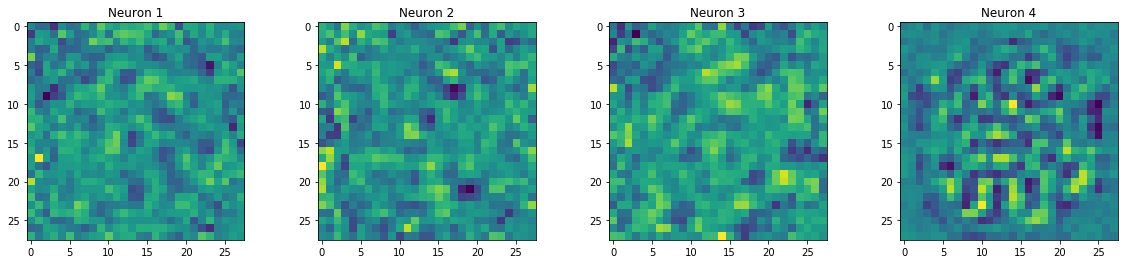

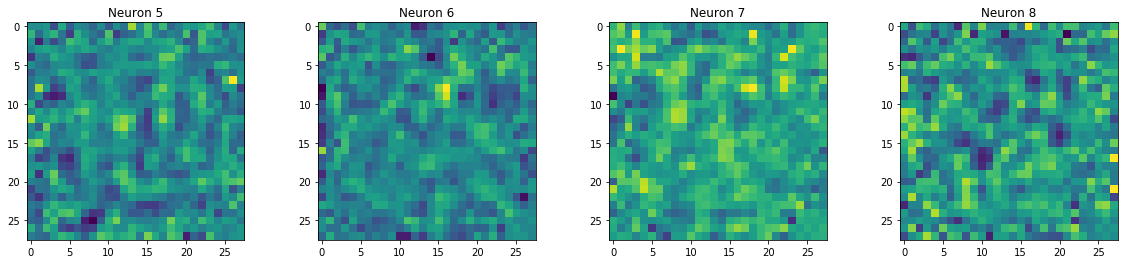

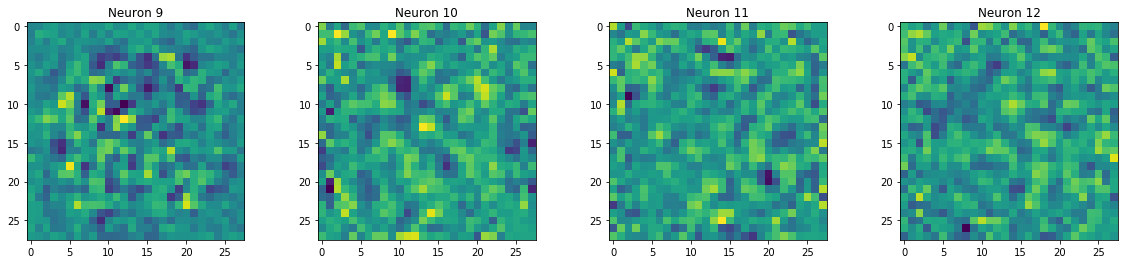

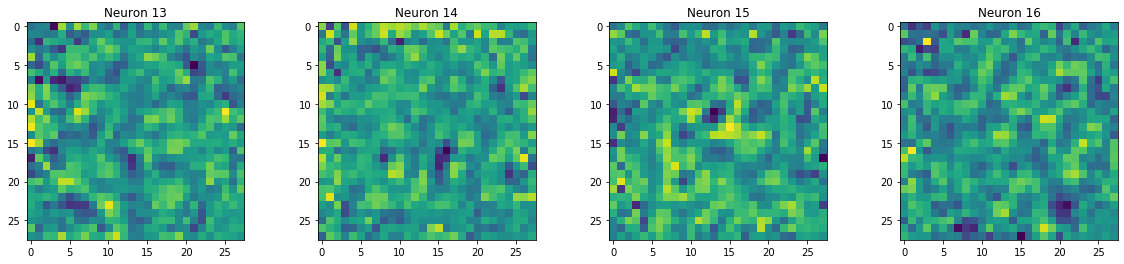

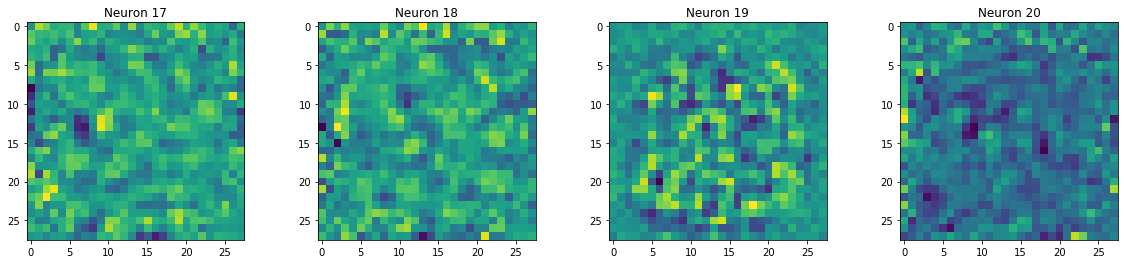

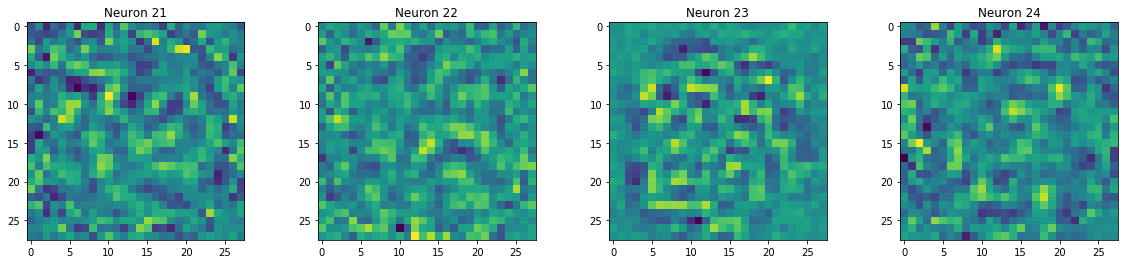

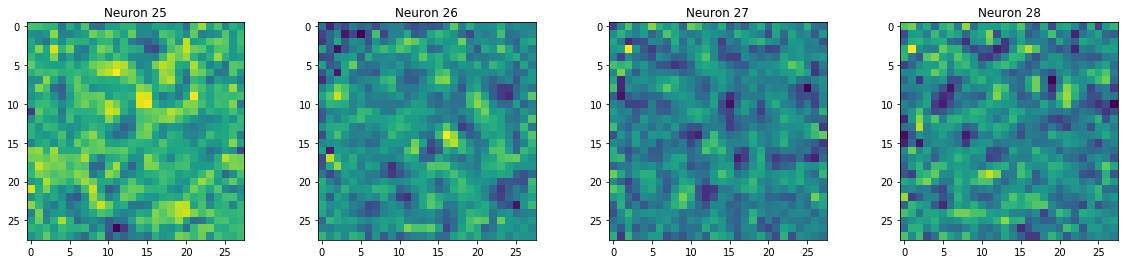

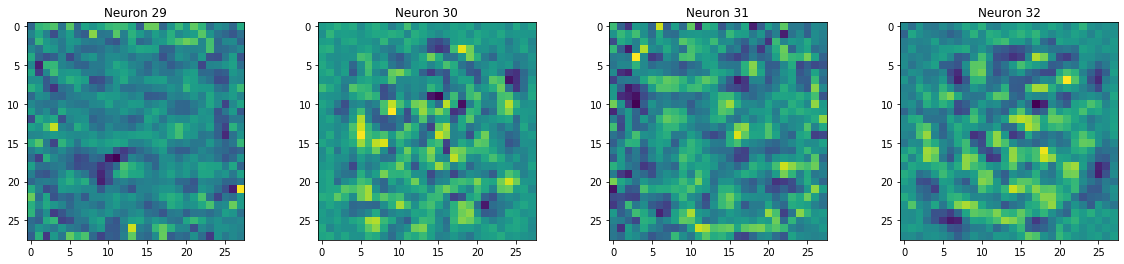

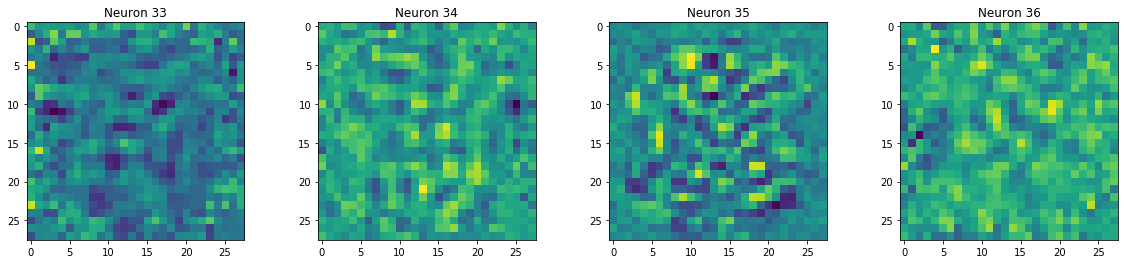

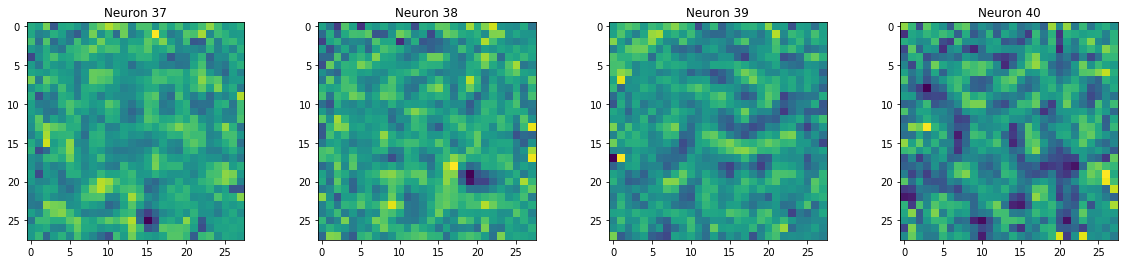

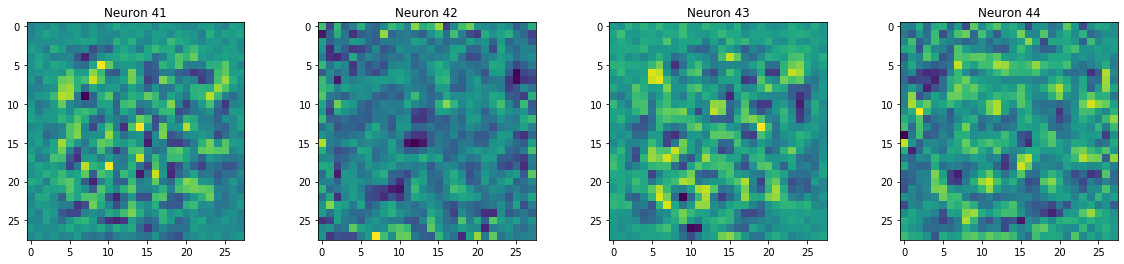

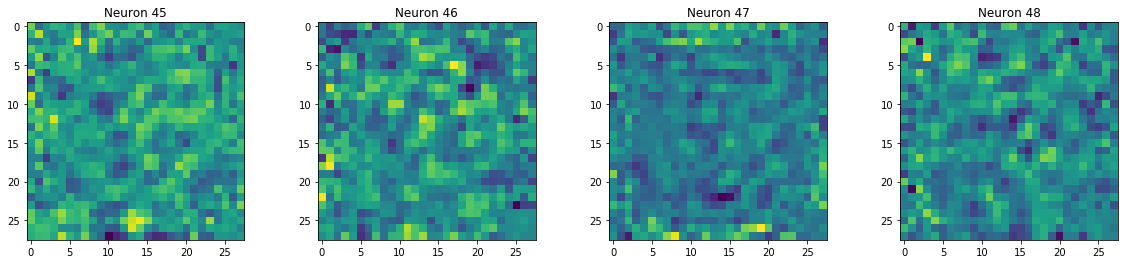

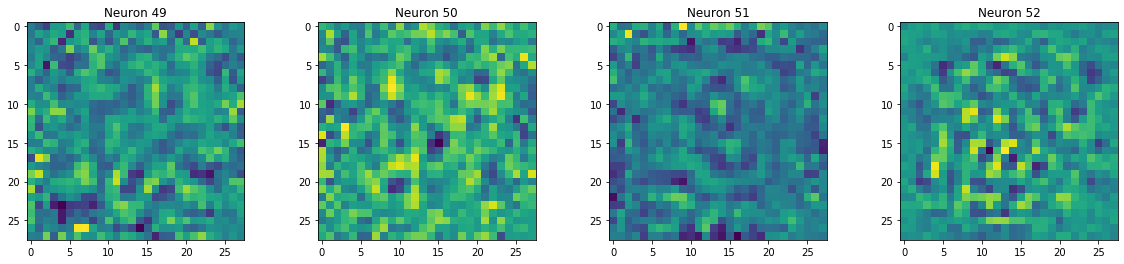

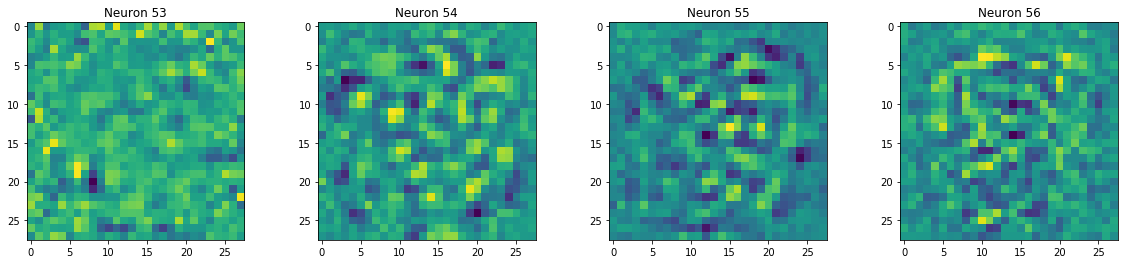

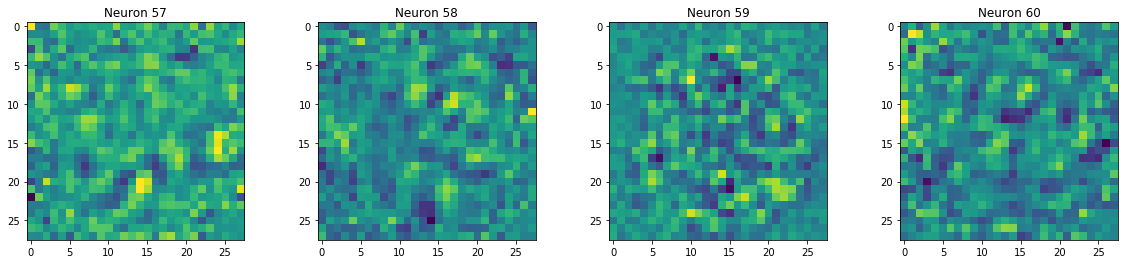

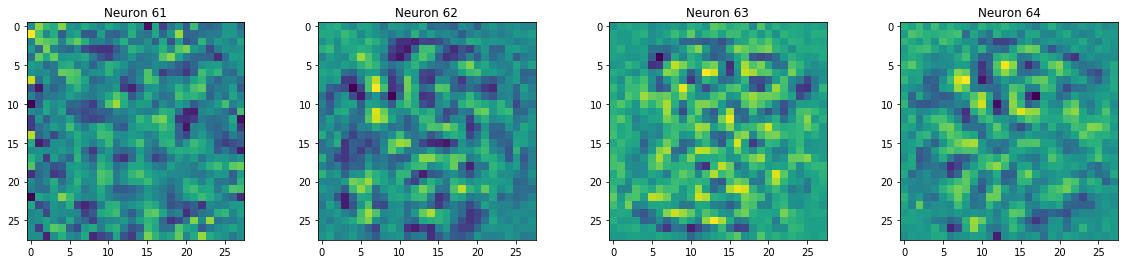

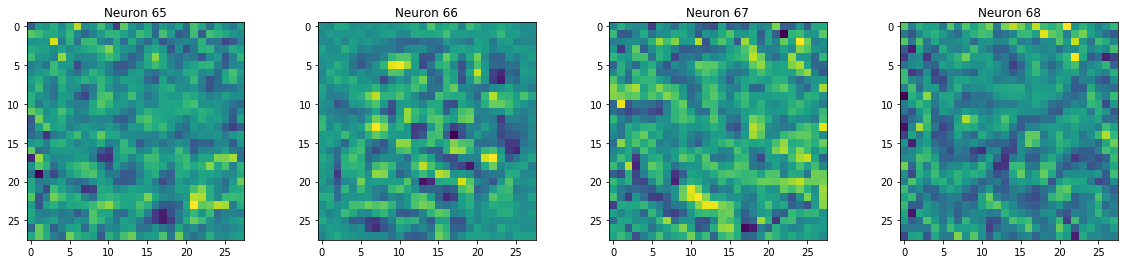

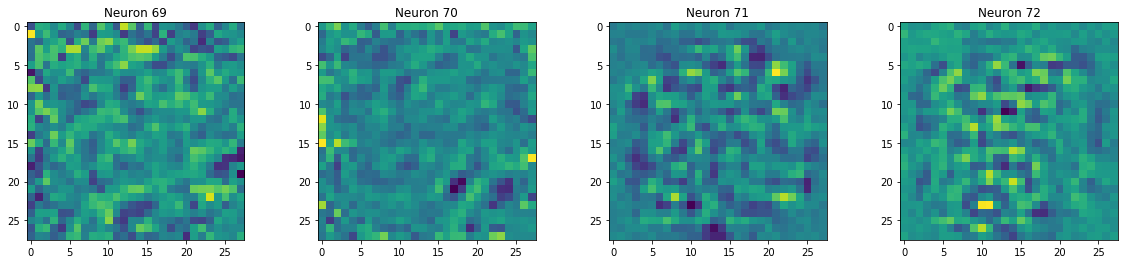

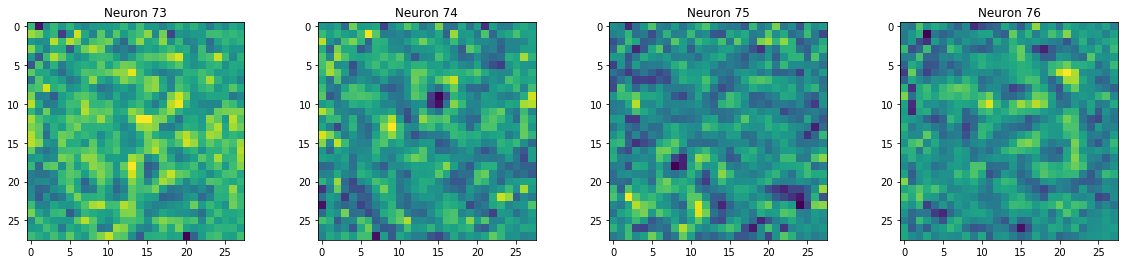

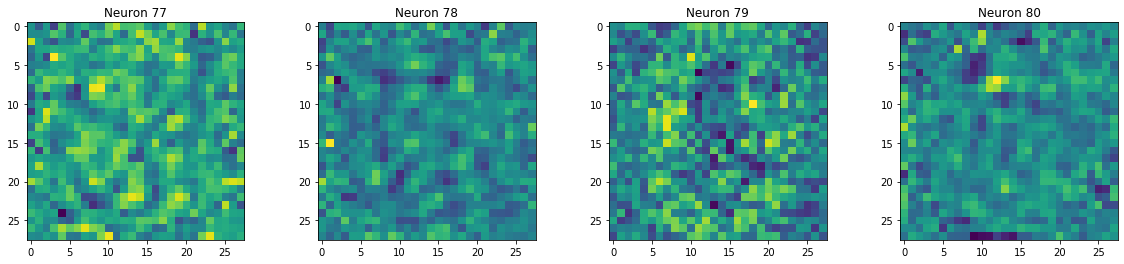

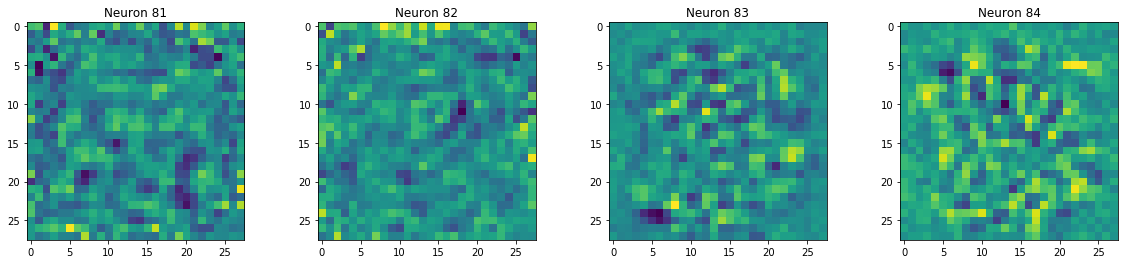

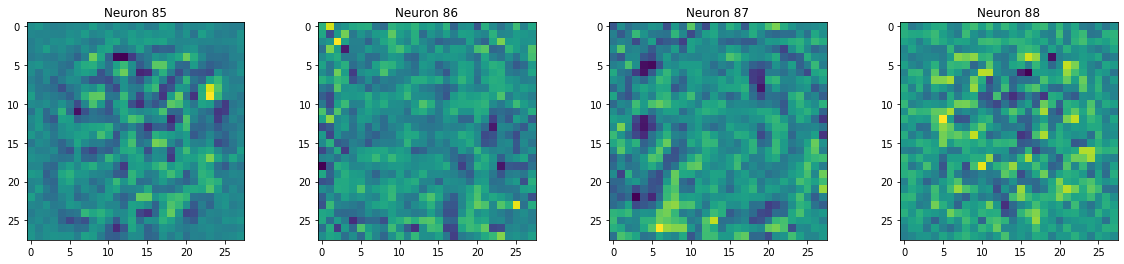

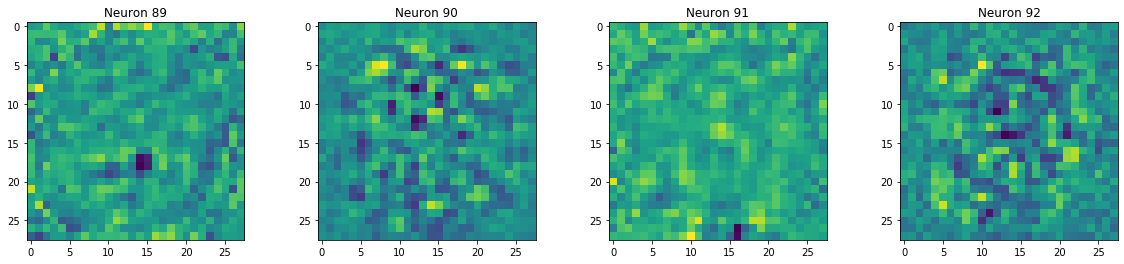

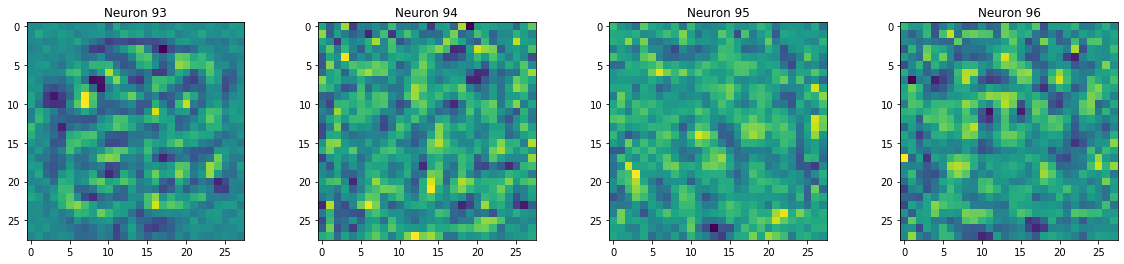

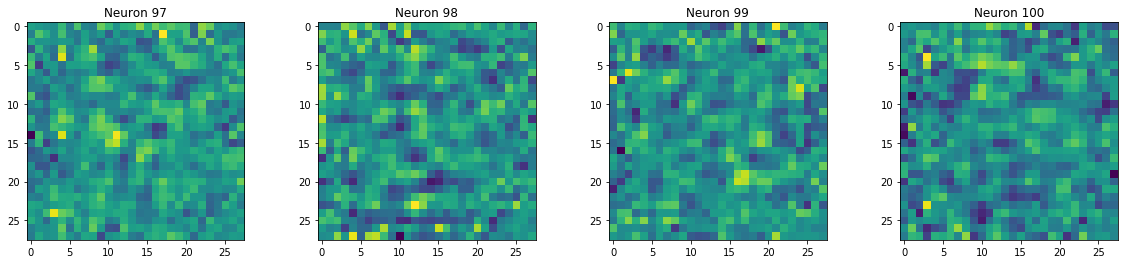

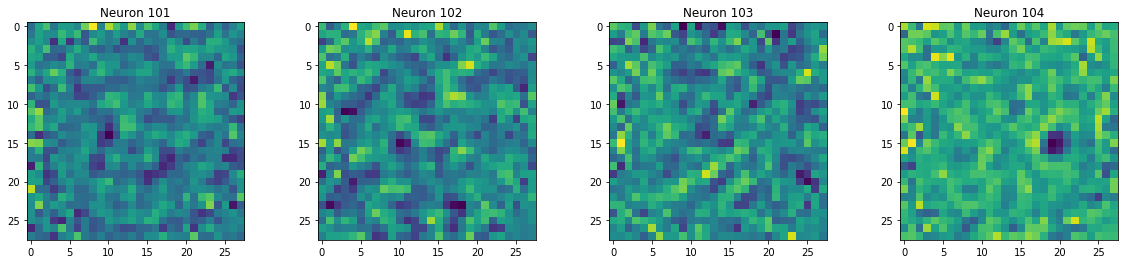

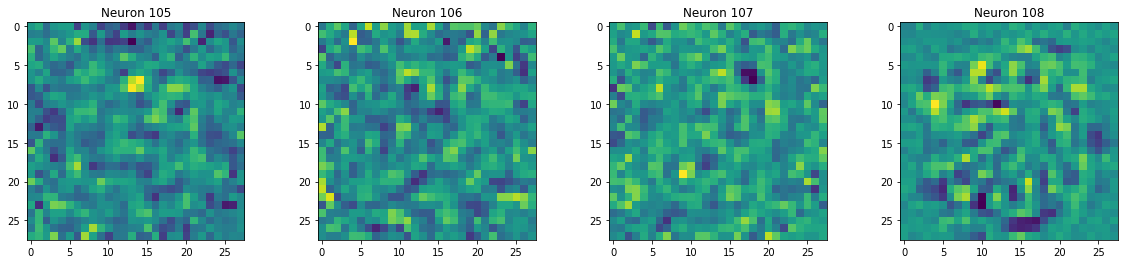

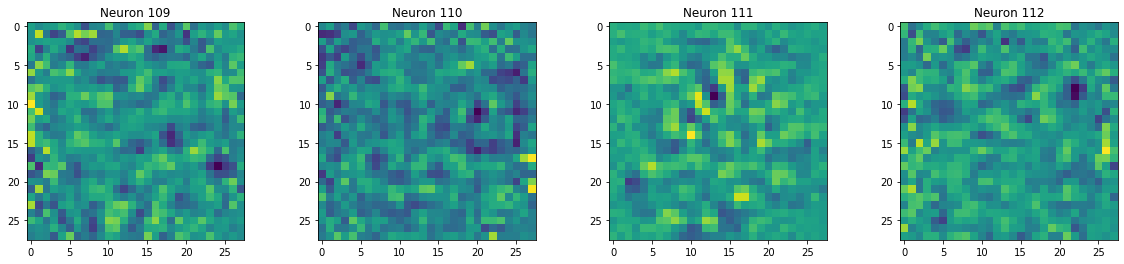

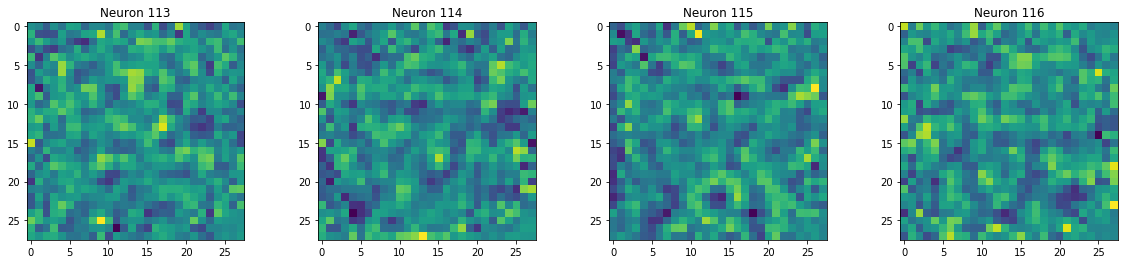

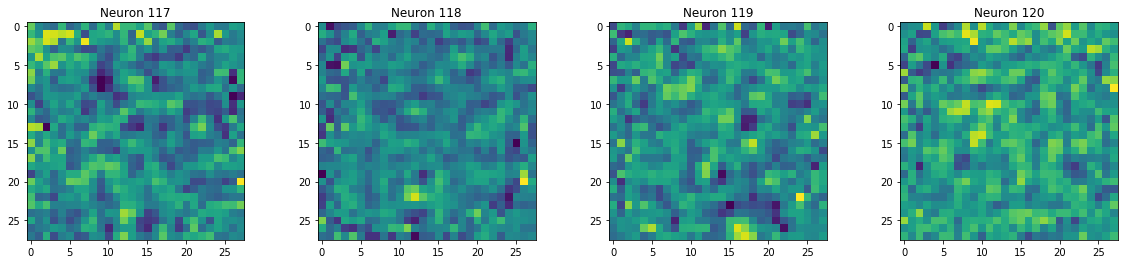

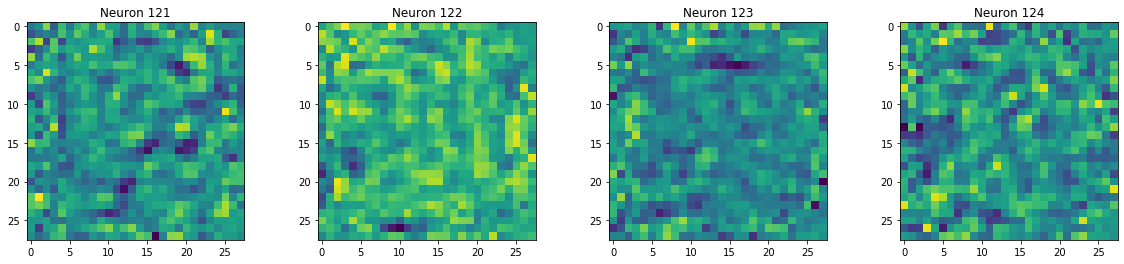

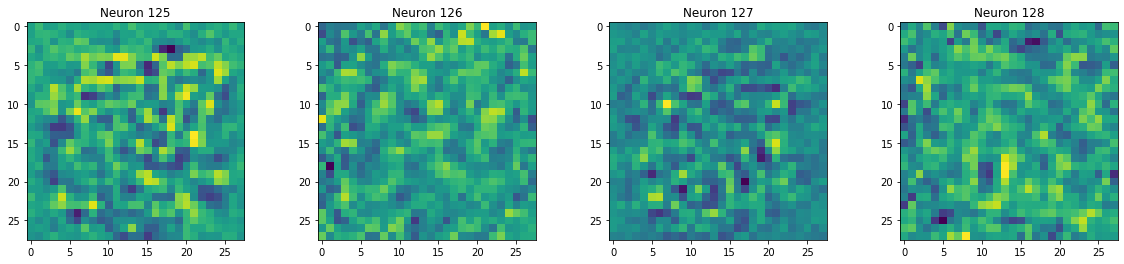

In [32]:
weight_visualization(best_arch["Hidden Layer 1"])

In [33]:
train_data.shape

(11385, 28, 28)

In [103]:
class Noise(tf.keras.layers.Layer):
    def __init__(self, mean=0, stddev=1.0, p = 0.2, *args, **kwargs):
        super(Noise, self).__init__(*args, **kwargs)
        self.mean = mean
        self.stddev = stddev
        self.p = p

    def call(self, inputs, 
             training=False # Only add noise in training!
             ):
        # print(inputs.shape)
        random_number = tf.random.uniform((1, ), minval = 0, maxval = 1)[0]
        if training and random_number >= self.p:
            return inputs + tf.random.normal(
                tf.shape(inputs), 
                mean=self.mean,
                stddev=self.stddev
            )
        else:
            return inputs



In [155]:
random_number = tf.random.uniform((1, ), minval = 0, maxval = 1)[0]
print(random_number)

tf.Tensor(0.59462535, shape=(), dtype=float32)


In [106]:

bottle_neck_dim = 128

autoencoder_noise = tf.keras.Sequential([
     tf.keras.Input((28, 28)),
     tf.keras.layers.Flatten(),
     Noise(stddev = 0.01, p=0.2),
     tf.keras.layers.Dense(bottle_neck_dim, activation = "sigmoid"),
     tf.keras.layers.Dense(784, activation = "sigmoid"),
    tf.keras.layers.Reshape((28, 28))
    ])

autoencoder_noise.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 noise_5 (Noise)             (None, 784)               0         
                                                                 
 dense_66 (Dense)            (None, 128)               100480    
                                                                 
 dense_67 (Dense)            (None, 784)               101136    
                                                                 
 reshape_12 (Reshape)        (None, 28, 28)            0         
                                                                 
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


In [107]:
input_img = tf.keras.layers.Input(shape=(28,28))
# input_img = tf.keras.Flatten()
noisy_input = tf.keras.Model(input_img, autoencoder_noise.layers[1](input_img))
print(autoencoder_noise.layers[2])
# Encoder 
encoder = tf.keras.models.Sequential(
    [
     input_img,
     tf.keras.layers.Flatten(),
     autoencoder_noise.layers[1], 
     autoencoder_noise.layers[2]
    ]
)
encoder.summary()
# print( autoencoder_noise.layers[-1].get_weights)

# Decoder
encoding_dim = tf.keras.Input((bottle_neck_dim, ))
decoder = tf.keras.models.Sequential([
    encoding_dim,
    autoencoder_noise.layers[-2],
    autoencoder_noise.layers[-1]
])
# decoder = tf.keras.Model(encoding_dim, 
#                          autoencoder_noise.layers[-2:](encoding_dim))

decoder.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 784)               0         
                                                                 
 noise_5 (Noise)             multiple                  0         
                                                                 
 dense_66 (Dense)            (None, 128)               100480    
                                                                 
Total params: 100,480
Trainable params: 100,480
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 784)               101136    
                                                                 
 reshape_12 (Reshape)   

In [108]:
myCallBack = ModelCallBack()
autoencoder_noise.compile(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.999,epsilon=1e-08),
              loss="mean_squared_error", metrics = ["mean_squared_error"])
autoencoder_noise.fit(train_data, train_data, epochs=1000, batch_size=32, verbose=0, callbacks=[myCallBack])

Epoch 0 done | MSE: 0.06485173851251602
Epoch 1 done | MSE: 0.041013527661561966
Epoch 2 done | MSE: 0.03165567293763161
Epoch 3 done | MSE: 0.025773266330361366
Epoch 4 done | MSE: 0.021565614268183708
Epoch 5 done | MSE: 0.01848910190165043
Epoch 6 done | MSE: 0.016128813847899437
Epoch 7 done | MSE: 0.0142825311049819
Epoch 8 done | MSE: 0.01282250415533781
Epoch 9 done | MSE: 0.011639091186225414
Epoch 10 done | MSE: 0.010667338967323303
Epoch 11 done | MSE: 0.009861504659056664
Epoch 12 done | MSE: 0.009184117428958416
Epoch 13 done | MSE: 0.008605726063251495
Epoch 14 done | MSE: 0.008102422580122948
Epoch 15 done | MSE: 0.007674034219235182
Epoch 16 done | MSE: 0.007278579752892256
Epoch 17 done | MSE: 0.006926082074642181
Epoch 18 done | MSE: 0.0066004726104438305
Epoch 19 done | MSE: 0.0063047148287296295
Epoch 20 done | MSE: 0.0060328212566673756
Epoch 21 done | MSE: 0.005779844708740711
Epoch 22 done | MSE: 0.005544345825910568
Epoch 23 done | MSE: 0.0053153871558606625
Epoc

In [109]:
def plot_AE_Re_and_orig_images(best_arch, data, randomlist):
     
#     randomlist = random.sample(range(len(data)), n)
    n = len(randomlist)
    plt.figure(figsize=(20, 4))
    t = 0
    for i in randomlist:
        encoded_imgs = encoder(train_data[i].reshape((1, 28, 28))).numpy()
        decoded_imgs = decoder(encoded_imgs).numpy()
        # display original
        ax = plt.subplot(2, n, t + 1)
        plt.imshow(train_data[i])
        plt.title("original")
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, t + 1 + n)
        plt.imshow(decoded_imgs.reshape((28,28)))
        plt.title("reconstructed")
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        t += 1
    plt.show()
#     return randomlist

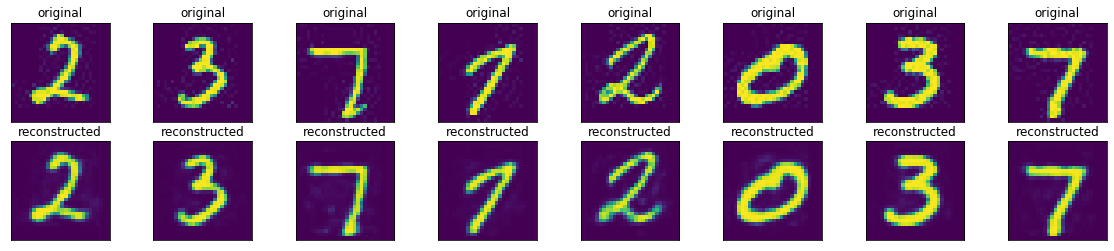

In [110]:
plot_AE_Re_and_orig_images(autoencoder_noise, train_data, h1_rl_train)

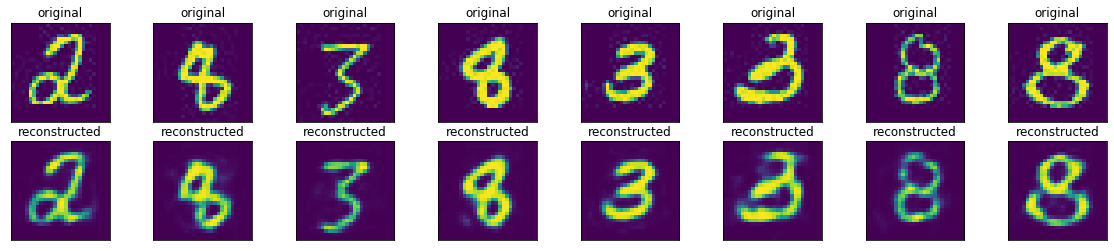

In [125]:
plot_AE_Re_and_orig_images(autoencoder_noise, val_data, h1_rl_val)

In [130]:

from fcnn import fcnn

def fcnn_on_compressed():

    encoded_train_imgs =encoder(train_data).numpy()
    encoded_test_imgs = encoder(test_data).numpy()
    encoded_val_imgs = encoder(val_data).numpy()

    fcnn_arch = [[64], [64,32,16],[128,32], [64,32], [32]]
#     best_arch_layers = best_arch.hidden_layers
#     input = best_arch_layers[len(best_arch_layers)//2]
#     print("fcnn Input:", input)
    fcnn_train_acc = []
    fcnn_test_acc = []
    fcnn_val_acc = []
    for arch in fcnn_arch:
        print("-"*25+"FCNN with Architecture: "+str(arch)+"-"*25)
        fcnn_model = fcnn((bottle_neck_dim,), arch, 5, "adam" ,False)
        fcnn_model._fit_(np.array(encoded_train_imgs), np.array(y_train))
        pred = fcnn_model.prediction(encoded_train_imgs)
        print("Confusion Matrix of Training Data")
        fcnn_model.confusion_matrix(pred, y_train)
        fcnn_train_acc.append(fcnn_model.accuracy(pred, y_train))

        pred = fcnn_model.prediction(encoded_val_imgs)
        print("Confusion Matrix of Validation Data")
        fcnn_model.confusion_matrix(pred, y_val)
        fcnn_val_acc.append(fcnn_model.accuracy(pred, y_val))
        
        pred = fcnn_model.prediction(encoded_test_imgs)
        print("Confusion Matrix of Test Data")
        fcnn_model.confusion_matrix(pred, y_test)
        fcnn_test_acc.append(fcnn_model.accuracy(pred, y_test))

        

    df = pd.DataFrame({
        "FCNN Architecture": fcnn_arch,
        "Training Accuracy": fcnn_train_acc,
        "Test Accuracy": fcnn_test_acc,
        "Validation Accuracy": fcnn_val_acc
    })
    display(df)


-------------------------FCNN with Architecture: [64]-------------------------
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 64)                4160      
                                                                 
 dense_89 (Dense)            (None, 5)                 325       
                                                                 
Total params: 4,485
Trainable params: 4,485
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.8863920569419861
Epoch 1 done | loss: 0.3112845718860626
Epoch 2 done | loss: 0.23008249700069427
Epoch 3 done | loss: 0.20516081154346466
Epoch 4 done | loss: 0.1923949122428894
Epoch 5 done | loss: 0.18401409685611725
Epoch 6 done | loss: 0.18073195219039917
Epoch 7 done | loss: 0.17385517060756683
Epoch 8 done | loss: 0.168030396103858

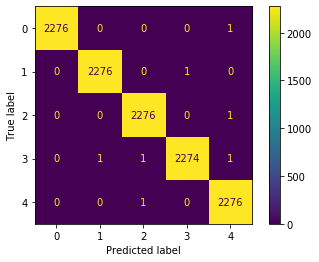

Confusion Matrix of Validation Data


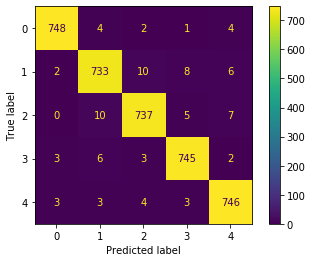

Confusion Matrix of Test Data


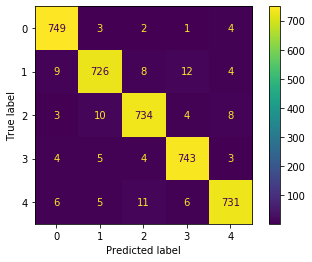

-------------------------FCNN with Architecture: [64, 32, 16]-------------------------
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 64)                4160      
                                                                 
 dense_91 (Dense)            (None, 32)                2080      
                                                                 
 dense_92 (Dense)            (None, 16)                528       
                                                                 
 dense_93 (Dense)            (None, 5)                 85        
                                                                 
Total params: 6,853
Trainable params: 6,853
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.6706036925315857
Epoch 1 done | loss: 0.22598321735858917
Epoch 2 do

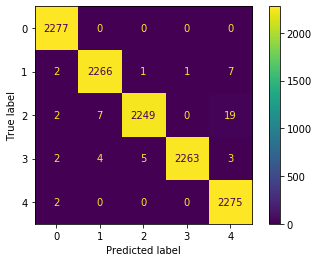

Confusion Matrix of Validation Data


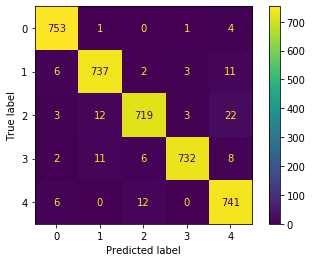

Confusion Matrix of Test Data


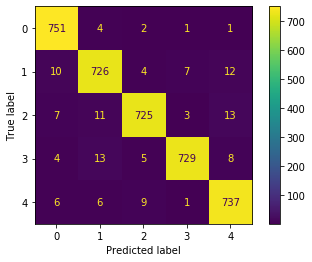

-------------------------FCNN with Architecture: [128, 32]-------------------------
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 128)               8320      
                                                                 
 dense_95 (Dense)            (None, 32)                4128      
                                                                 
 dense_96 (Dense)            (None, 5)                 165       
                                                                 
Total params: 12,613
Trainable params: 12,613
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.6313554644584656
Epoch 1 done | loss: 0.2160271853208542
Epoch 2 done | loss: 0.19160276651382446
Epoch 3 done | loss: 0.1804717481136322
Epoch 4 done | loss: 0.16548676788806915
Epoch 5 done | loss: 0

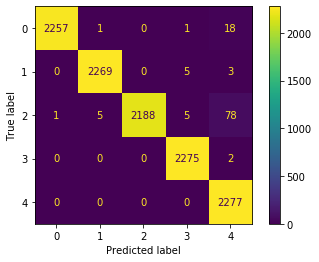

Confusion Matrix of Validation Data


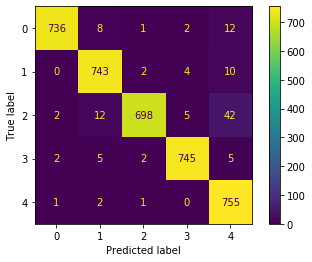

Confusion Matrix of Test Data


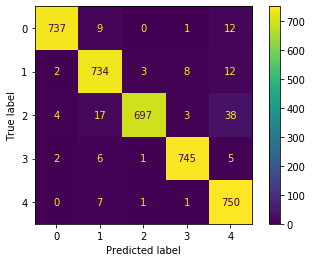

-------------------------FCNN with Architecture: [64, 32]-------------------------
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 64)                4160      
                                                                 
 dense_98 (Dense)            (None, 32)                2080      
                                                                 
 dense_99 (Dense)            (None, 5)                 165       
                                                                 
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.6983132362365723
Epoch 1 done | loss: 0.2294541448354721
Epoch 2 done | loss: 0.19296617805957794
Epoch 3 done | loss: 0.17902871966362
Epoch 4 done | loss: 0.17008329927921295
Epoch 5 done | loss: 0.1577

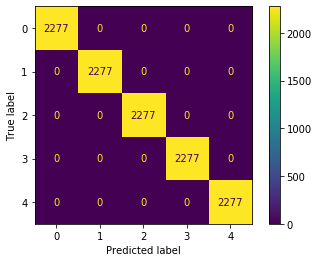

Confusion Matrix of Validation Data


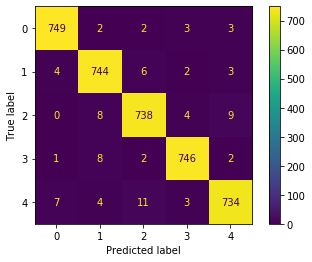

Confusion Matrix of Test Data


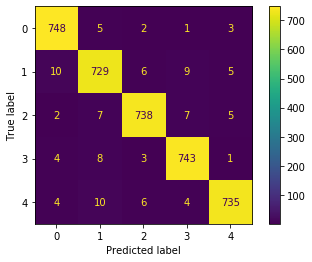

-------------------------FCNN with Architecture: [32]-------------------------
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 32)                2080      
                                                                 
 dense_101 (Dense)           (None, 5)                 165       
                                                                 
Total params: 2,245
Trainable params: 2,245
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 1.0330278873443604
Epoch 1 done | loss: 0.4064025580883026
Epoch 2 done | loss: 0.27293142676353455
Epoch 3 done | loss: 0.22938844561576843
Epoch 4 done | loss: 0.209200918674469
Epoch 5 done | loss: 0.19874945282936096
Epoch 6 done | loss: 0.19176848232746124
Epoch 7 done | loss: 0.18792124092578888
Epoch 8 done | loss: 0.1840250939130783

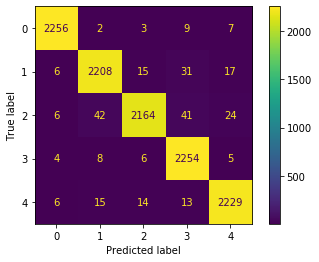

Confusion Matrix of Validation Data


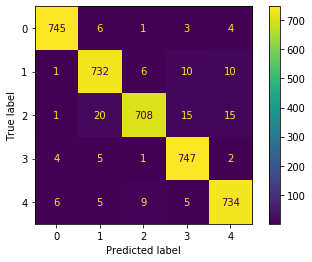

Confusion Matrix of Test Data


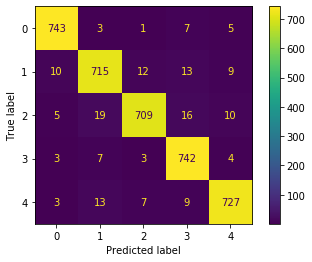

,FCNN Architecture,Training Accuracy,Test Accuracy,Validation Accuracy
0,[64],0.999385,0.970487,0.977339
1,"[64, 32, 16]",0.995169,0.966535,0.970224
2,"[128, 32]",0.989548,0.965217,0.968906
3,"[64, 32]",1.000000,0.973123,0.977866
4,[32],0.975933,0.958103,0.966008


In [131]:
fcnn_on_compressed()

In [132]:
weights = autoencoder_noise.layers[2].weights[0].shape
print(weights)

(784, 64)


In [135]:
def weight_visualization(best_arch):

    weights = best_arch.layers[2].get_weights()[0]
    print("Weights Shape:",weights.shape)
    weights = weights.T
    i = 0
    k = 0
    
    # t = 0
    for i in range(16):
        plt.figure(figsize=(20, 4))
        j = 4*i
        for k in range(4):
            plt.subplot(1,4,k+1)
            plt.imshow(weights[j+k].reshape((28,28)))
            plt.title("Neuron {}".format(j+k+1))
            # t+=1
        plt.show()

Weights Shape: (784, 64)


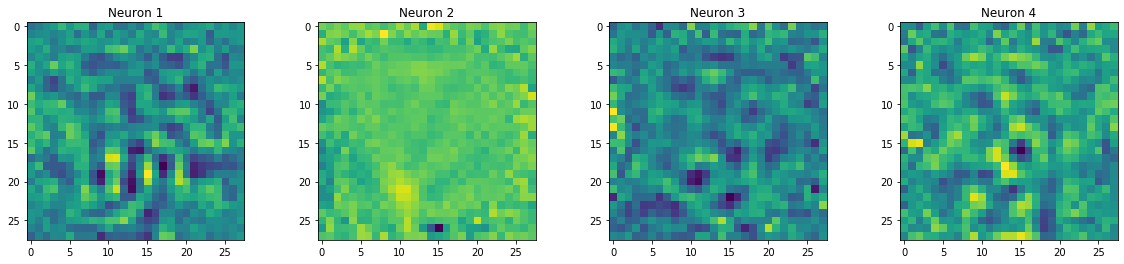

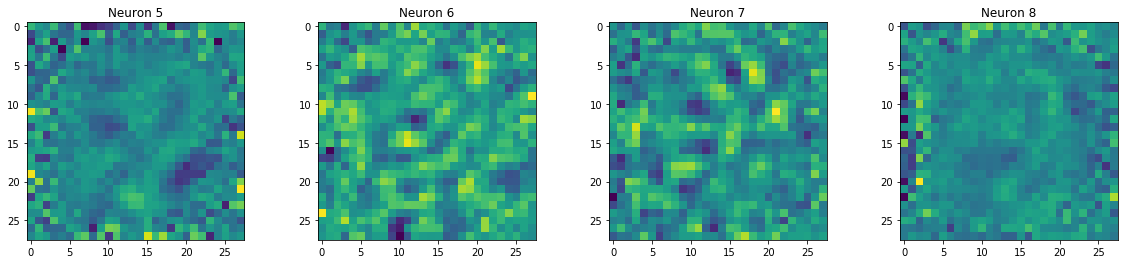

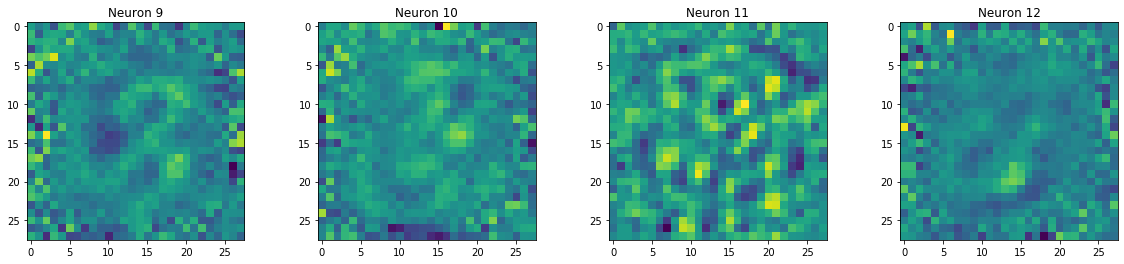

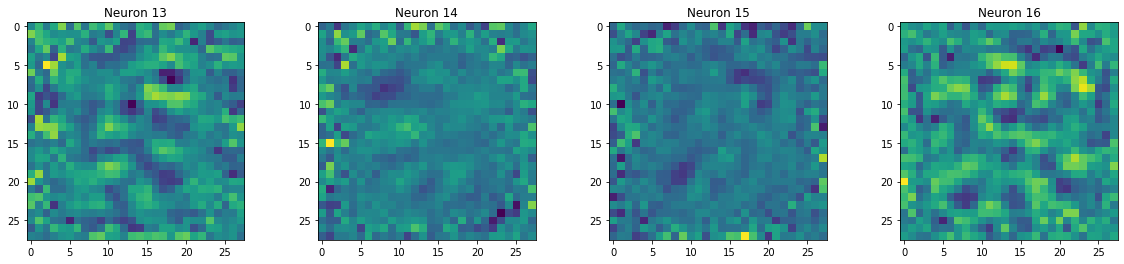

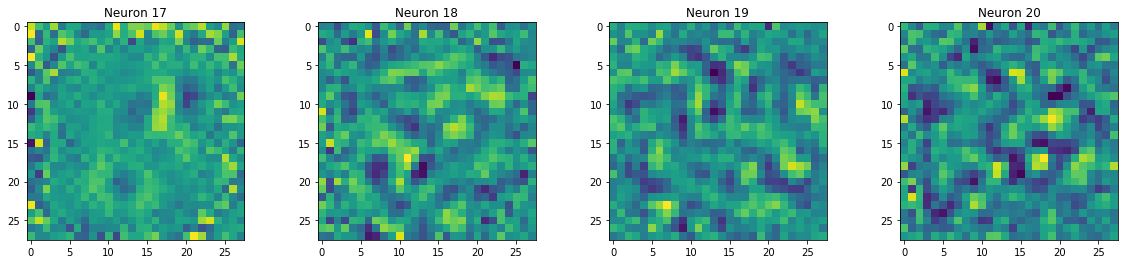

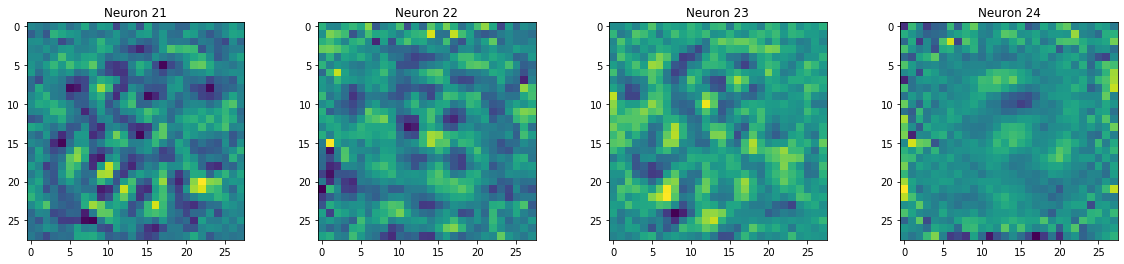

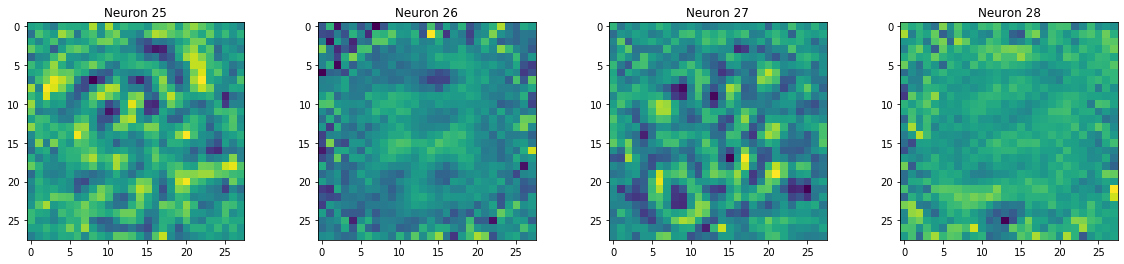

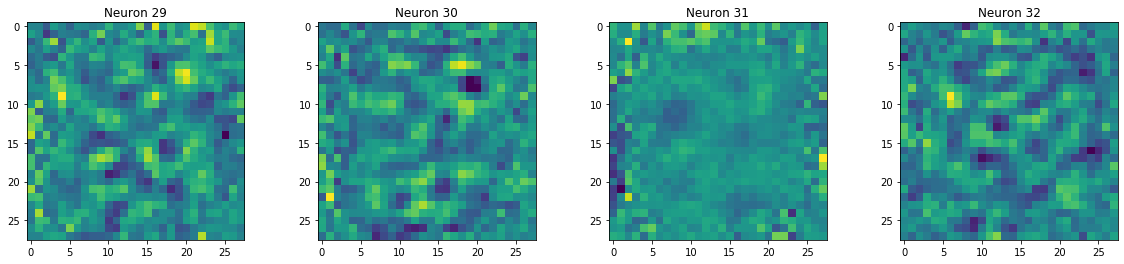

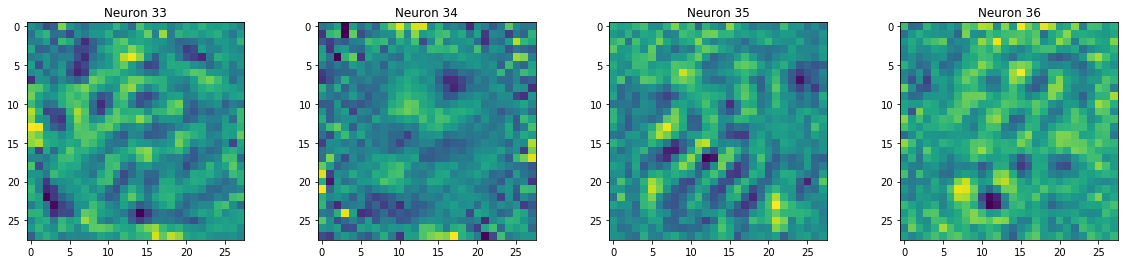

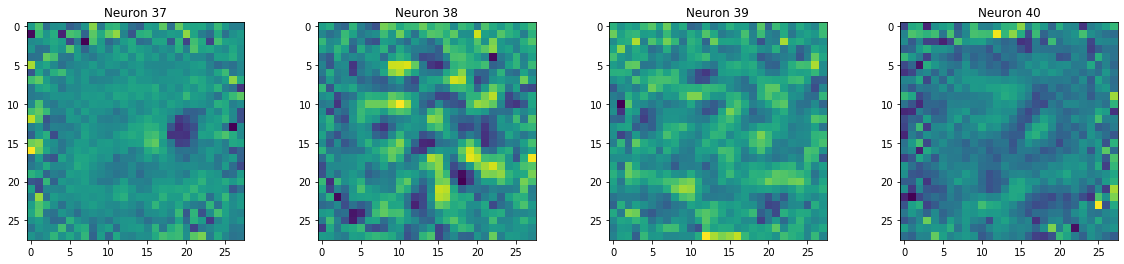

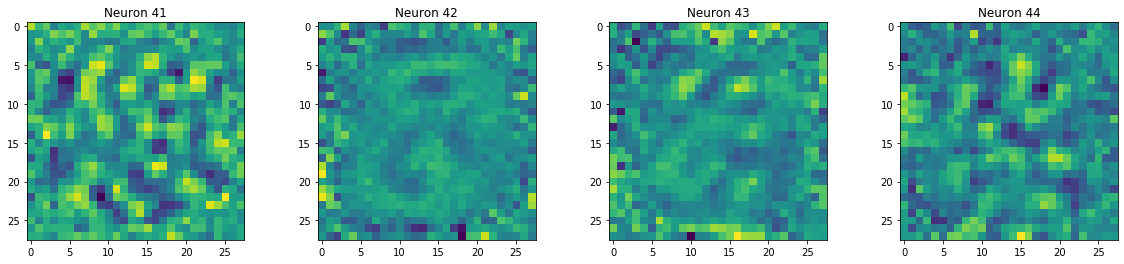

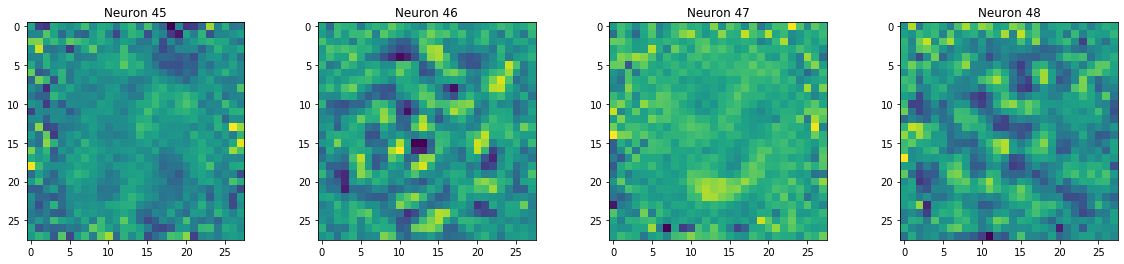

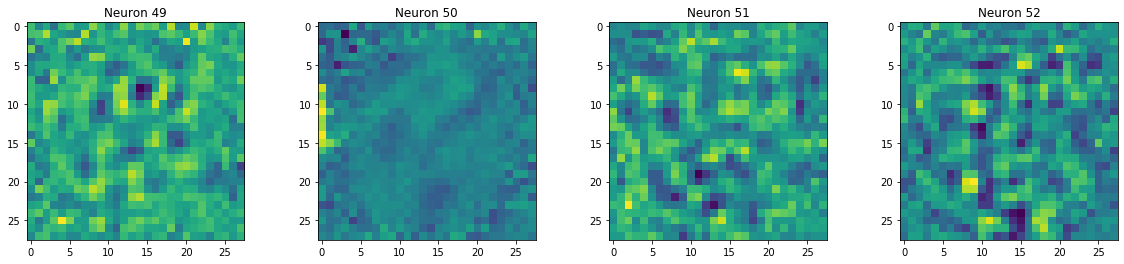

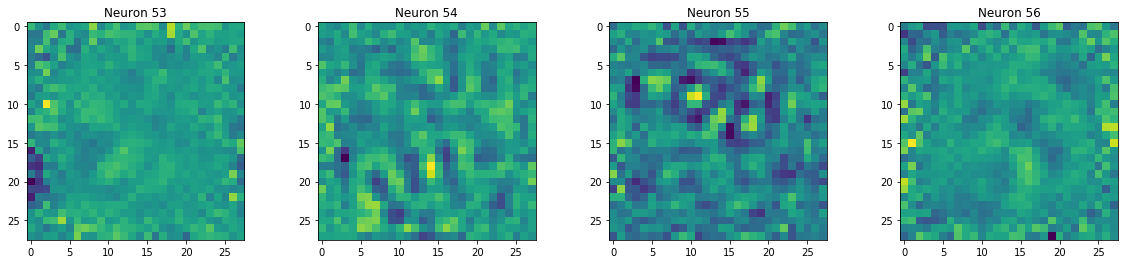

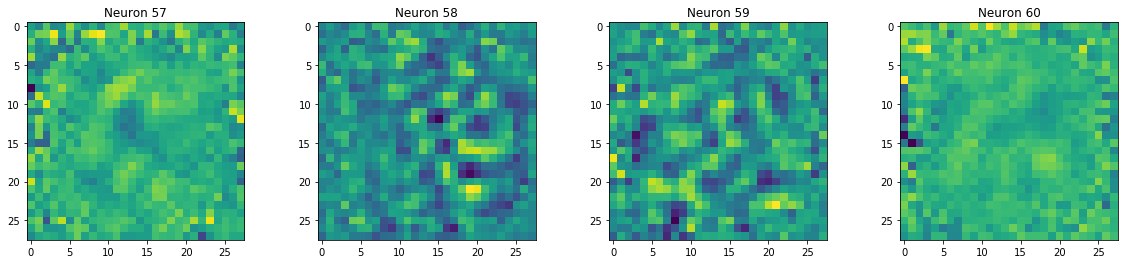

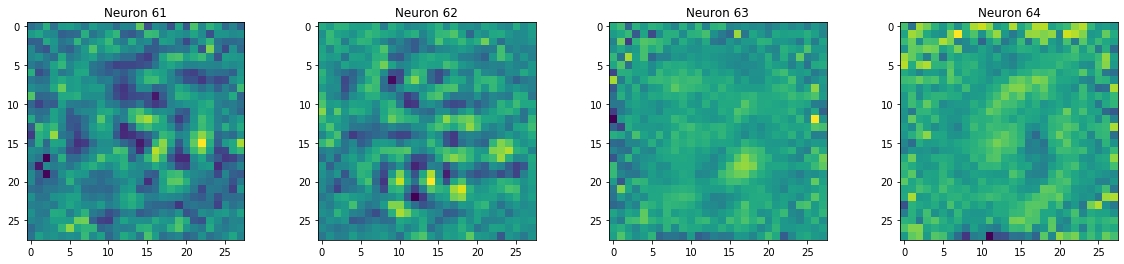

In [136]:
weight_visualization(autoencoder_noise)

In [146]:

bottle_neck_dim = 128

autoencoder_noise = tf.keras.Sequential([
     tf.keras.Input((28, 28)),
     tf.keras.layers.Flatten(),
     Noise(stddev = 0.01, p=0.4),
     tf.keras.layers.Dense(bottle_neck_dim, activation = "sigmoid"),
     tf.keras.layers.Dense(784, activation = "sigmoid"),
    tf.keras.layers.Reshape((28, 28))
    ])



In [147]:
input_img = tf.keras.layers.Input(shape=(28,28))
# input_img = tf.keras.Flatten()
noisy_input = tf.keras.Model(input_img, autoencoder_noise.layers[1](input_img))
# print(autoencoder_noise.layers[2])
# Encoder 
encoder = tf.keras.models.Sequential(
    [
     input_img,
     tf.keras.layers.Flatten(),
     autoencoder_noise.layers[1], 
     autoencoder_noise.layers[2]
    ]
)
encoder.summary()
# print( autoencoder_noise.layers[-1].get_weights)

# Decoder
encoding_dim = tf.keras.Input((128, ))
decoder = tf.keras.models.Sequential([
    encoding_dim,
    autoencoder_noise.layers[-2],
    autoencoder_noise.layers[-1]
])
# decoder = tf.keras.Model(encoding_dim, 
#                          autoencoder_noise.layers[-2:](encoding_dim))

decoder.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 784)               0         
                                                                 
 noise_8 (Noise)             multiple                  0         
                                                                 
 dense_104 (Dense)           (None, 128)               100480    
                                                                 
Total params: 100,480
Trainable params: 100,480
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 784)               101136    
                                                                 
 reshape_15 (Reshape)   

In [148]:
myCallBack = ModelCallBack()
autoencoder_noise.compile(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.999,epsilon=1e-08),
              loss="mean_squared_error", metrics = ["mean_squared_error"])
autoencoder_noise.fit(train_data, train_data, epochs=1000, batch_size=32, verbose=0, callbacks=[myCallBack])

Epoch 0 done | MSE: 0.06481584161520004
Epoch 1 done | MSE: 0.04109560698270798
Epoch 2 done | MSE: 0.03166517987847328
Epoch 3 done | MSE: 0.025782588869333267
Epoch 4 done | MSE: 0.02165990136563778
Epoch 5 done | MSE: 0.018556930124759674
Epoch 6 done | MSE: 0.01619916595518589
Epoch 7 done | MSE: 0.01435868814587593
Epoch 8 done | MSE: 0.012888685800135136
Epoch 9 done | MSE: 0.011688725091516972
Epoch 10 done | MSE: 0.010703223757445812
Epoch 11 done | MSE: 0.009878424927592278
Epoch 12 done | MSE: 0.009174798615276814
Epoch 13 done | MSE: 0.008568796329200268
Epoch 14 done | MSE: 0.008036870509386063
Epoch 15 done | MSE: 0.007580704987049103
Epoch 16 done | MSE: 0.007162954192608595
Epoch 17 done | MSE: 0.00679903756827116
Epoch 18 done | MSE: 0.006471176166087389
Epoch 19 done | MSE: 0.006170033011585474
Epoch 20 done | MSE: 0.00588964344933629
Epoch 21 done | MSE: 0.005636661313474178
Epoch 22 done | MSE: 0.0054043433628976345
Epoch 23 done | MSE: 0.0051806652918457985
Epoch 24

In [149]:
def plot_AE_Re_and_orig_images(best_arch, data, randomlist):
     
#     randomlist = random.sample(range(len(data)), n)
    n = len(randomlist)
    plt.figure(figsize=(20, 4))
    t = 0
    for i in randomlist:
        encoded_imgs = encoder(train_data[i].reshape((1, 28, 28))).numpy()
        decoded_imgs = decoder(encoded_imgs).numpy()
        # display original
        ax = plt.subplot(2, n, t + 1)
        plt.imshow(train_data[i])
        plt.title("original")
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, t + 1 + n)
        plt.imshow(decoded_imgs.reshape((28,28)))
        plt.title("reconstructed")
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        t += 1
    plt.show()
#     return randomlist

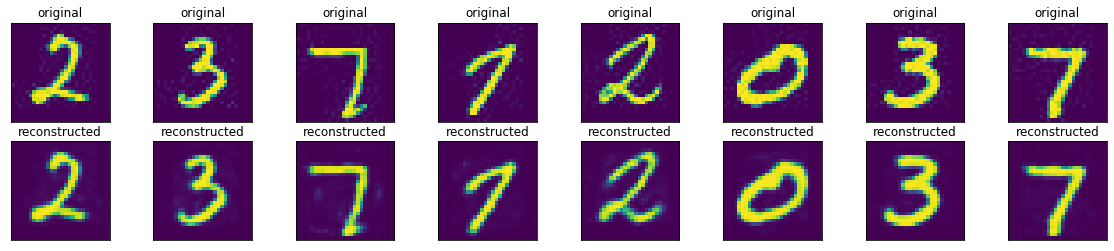

In [150]:
plot_AE_Re_and_orig_images(autoencoder_noise, train_data, h1_rl_train)

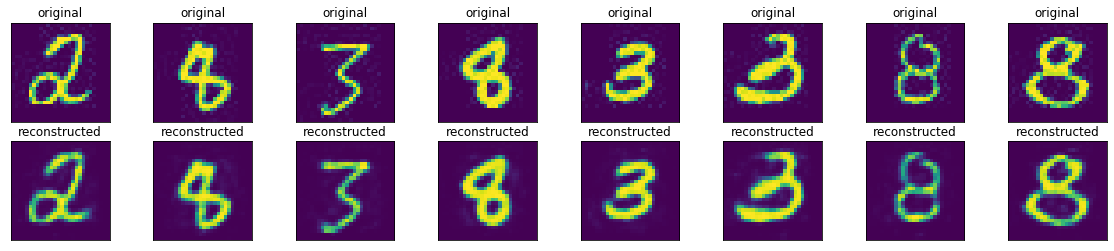

In [151]:
plot_AE_Re_and_orig_images(autoencoder_noise, val_data, h1_rl_val)

In [152]:

from fcnn import fcnn

def fcnn_on_compressed():

    encoded_train_imgs =encoder(train_data).numpy()
    encoded_test_imgs = encoder(test_data).numpy()
    encoded_val_imgs = encoder(val_data).numpy()

    fcnn_arch = [[64], [64,32,16],[128,32], [64,32], [32]]
#     best_arch_layers = best_arch.hidden_layers
#     input = best_arch_layers[len(best_arch_layers)//2]
#     print("fcnn Input:", input)
    fcnn_train_acc = []
    fcnn_test_acc = []
    fcnn_val_acc = []
    for arch in fcnn_arch:
        print("-"*25+"FCNN with Architecture: "+str(arch)+"-"*25)
        fcnn_model = fcnn((bottle_neck_dim,), arch, 5, "adam" ,False)
        fcnn_model._fit_(np.array(encoded_train_imgs), np.array(y_train))
        pred = fcnn_model.prediction(encoded_train_imgs)
        print("Confusion Matrix of Training Data")
        fcnn_model.confusion_matrix(pred, y_train)
        fcnn_train_acc.append(fcnn_model.accuracy(pred, y_train))

        pred = fcnn_model.prediction(encoded_val_imgs)
        print("Confusion Matrix of Validation Data")
        fcnn_model.confusion_matrix(pred, y_val)
        fcnn_val_acc.append(fcnn_model.accuracy(pred, y_val))
        
        pred = fcnn_model.prediction(encoded_test_imgs)
        print("Confusion Matrix of Test Data")
        fcnn_model.confusion_matrix(pred, y_test)
        fcnn_test_acc.append(fcnn_model.accuracy(pred, y_test))

        

    df = pd.DataFrame({
        "FCNN Architecture": fcnn_arch,
        "Training Accuracy": fcnn_train_acc,
        "Test Accuracy": fcnn_test_acc,
        "Validation Accuracy": fcnn_val_acc
    })
    display(df)


-------------------------FCNN with Architecture: [64]-------------------------
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (None, 64)                8256      
                                                                 
 dense_107 (Dense)           (None, 5)                 325       
                                                                 
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.7016651630401611
Epoch 1 done | loss: 0.25439757108688354
Epoch 2 done | loss: 0.20291845500469208
Epoch 3 done | loss: 0.18489746749401093
Epoch 4 done | loss: 0.17301161587238312
Epoch 5 done | loss: 0.16431595385074615
Epoch 6 done | loss: 0.15514981746673584
Epoch 7 done | loss: 0.14697332680225372
Epoch 8 done | loss: 0.1363220661878

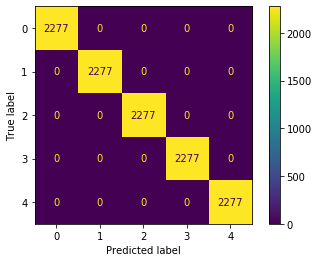

Confusion Matrix of Validation Data


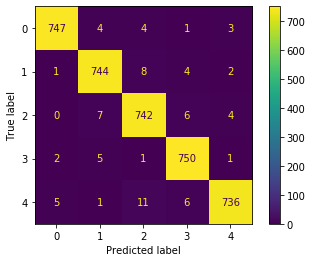

Confusion Matrix of Test Data


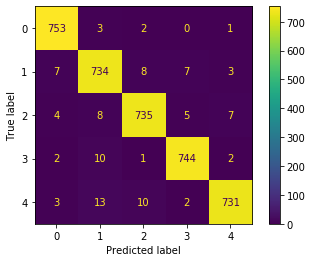

-------------------------FCNN with Architecture: [64, 32, 16]-------------------------
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 64)                8256      
                                                                 
 dense_109 (Dense)           (None, 32)                2080      
                                                                 
 dense_110 (Dense)           (None, 16)                528       
                                                                 
 dense_111 (Dense)           (None, 5)                 85        
                                                                 
Total params: 10,949
Trainable params: 10,949
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.5948241949081421
Epoch 1 done | loss: 0.21580351889133453
Epoch 2 

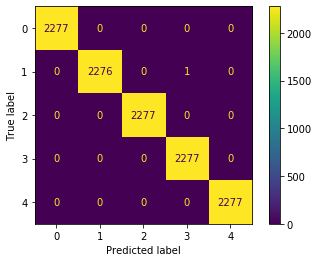

Confusion Matrix of Validation Data


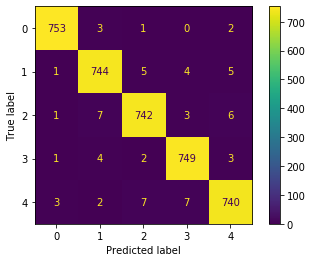

Confusion Matrix of Test Data


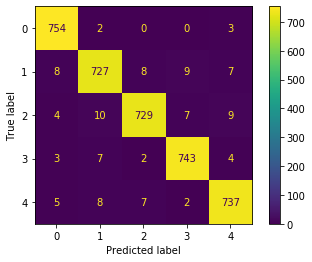

-------------------------FCNN with Architecture: [128, 32]-------------------------
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 128)               16512     
                                                                 
 dense_113 (Dense)           (None, 32)                4128      
                                                                 
 dense_114 (Dense)           (None, 5)                 165       
                                                                 
Total params: 20,805
Trainable params: 20,805
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.4599550664424896
Epoch 1 done | loss: 0.19961951673030853
Epoch 2 done | loss: 0.18073926866054535
Epoch 3 done | loss: 0.16344042122364044
Epoch 4 done | loss: 0.14544744789600372
Epoch 5 done | loss:

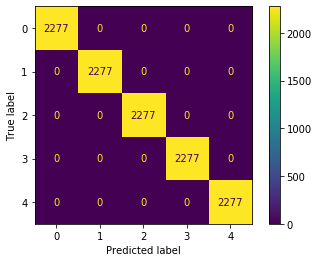

Confusion Matrix of Validation Data


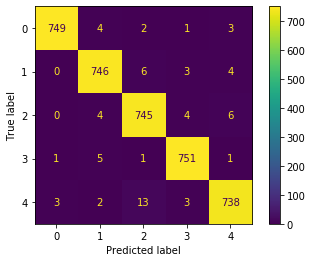

Confusion Matrix of Test Data


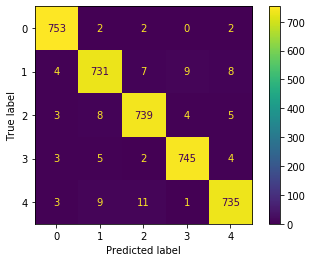

-------------------------FCNN with Architecture: [64, 32]-------------------------
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 64)                8256      
                                                                 
 dense_116 (Dense)           (None, 32)                2080      
                                                                 
 dense_117 (Dense)           (None, 5)                 165       
                                                                 
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.5480743646621704
Epoch 1 done | loss: 0.20932364463806152
Epoch 2 done | loss: 0.18299075961112976
Epoch 3 done | loss: 0.1644809991121292
Epoch 4 done | loss: 0.14832350611686707
Epoch 5 done | loss: 0

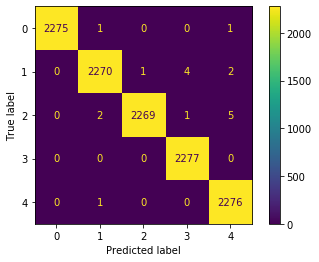

Confusion Matrix of Validation Data


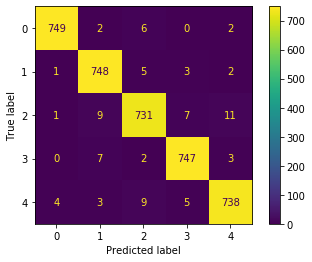

Confusion Matrix of Test Data


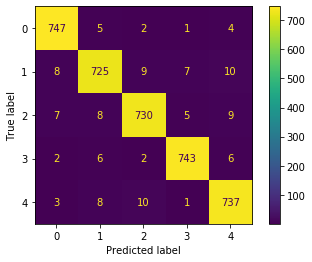

-------------------------FCNN with Architecture: [32]-------------------------
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_118 (Dense)           (None, 32)                4128      
                                                                 
 dense_119 (Dense)           (None, 5)                 165       
                                                                 
Total params: 4,293
Trainable params: 4,293
Non-trainable params: 0
_________________________________________________________________
adam
Epoch 0 done | loss: 0.7881565093994141
Epoch 1 done | loss: 0.29500389099121094
Epoch 2 done | loss: 0.22364510595798492
Epoch 3 done | loss: 0.20057928562164307
Epoch 4 done | loss: 0.18570145964622498
Epoch 5 done | loss: 0.17453159391880035
Epoch 6 done | loss: 0.1699194759130478
Epoch 7 done | loss: 0.16358956694602966
Epoch 8 done | loss: 0.15917263925075

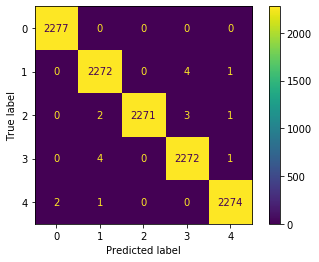

Confusion Matrix of Validation Data


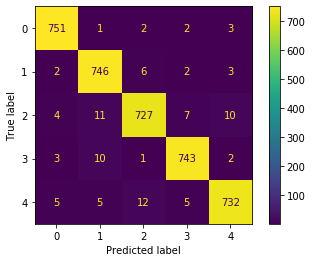

Confusion Matrix of Test Data


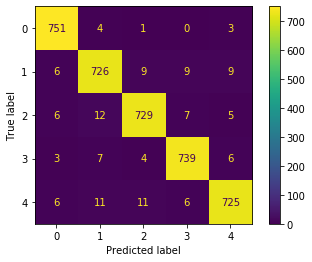

,FCNN Architecture,Training Accuracy,Test Accuracy,Validation Accuracy
0,[64],1.000000,0.974177,0.979974
1,"[64, 32, 16]",0.999912,0.972332,0.982345
2,"[128, 32]",1.000000,0.975758,0.982609
3,"[64, 32]",0.998419,0.970224,0.978393
4,[32],0.998331,0.967062,0.974704


In [153]:
fcnn_on_compressed()

Weights Shape: (784, 128)


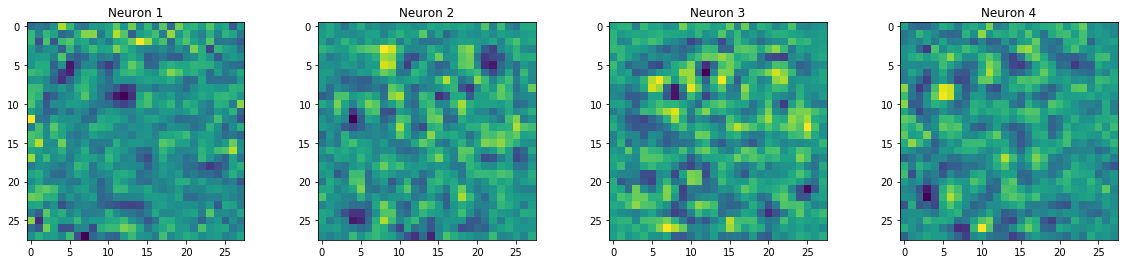

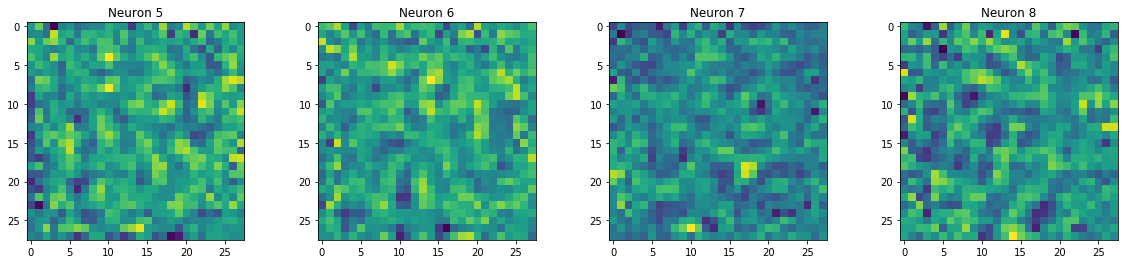

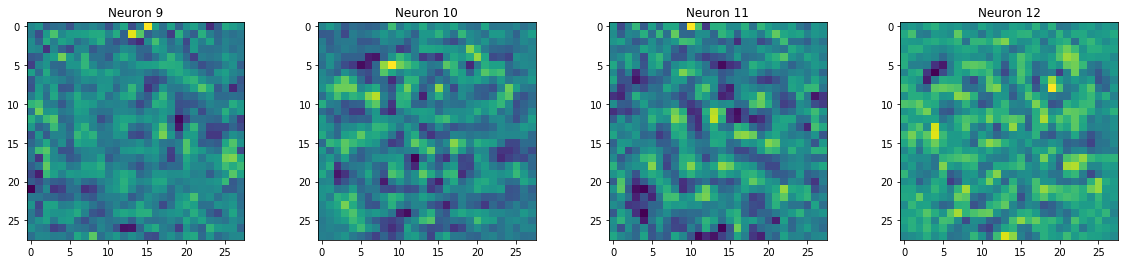

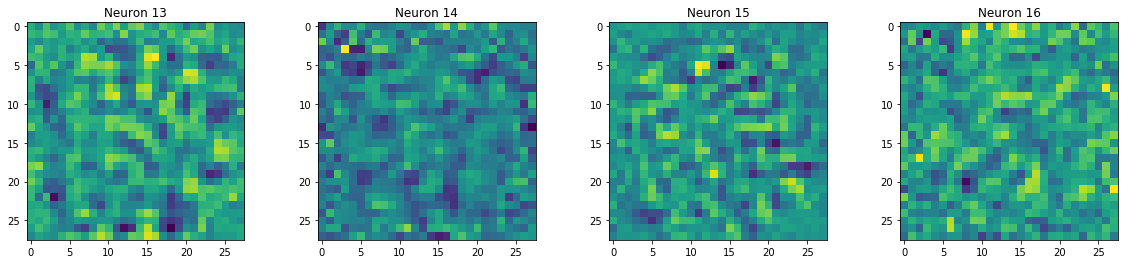

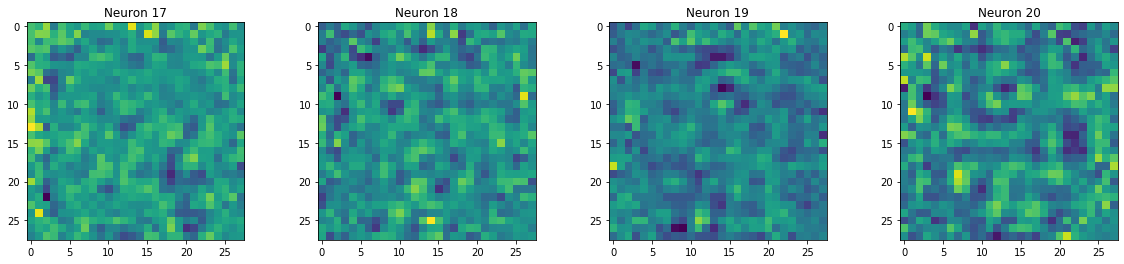

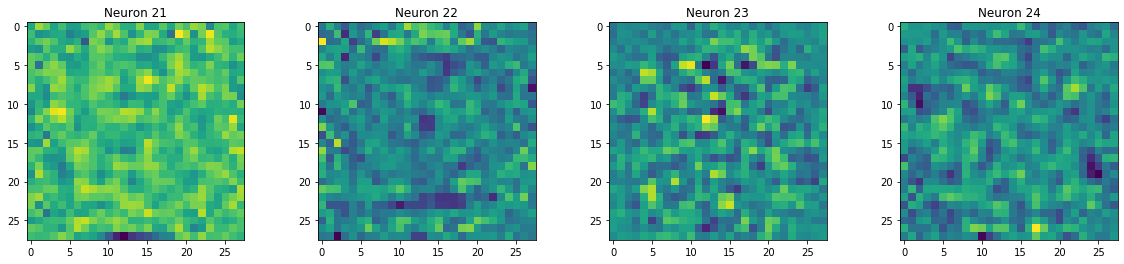

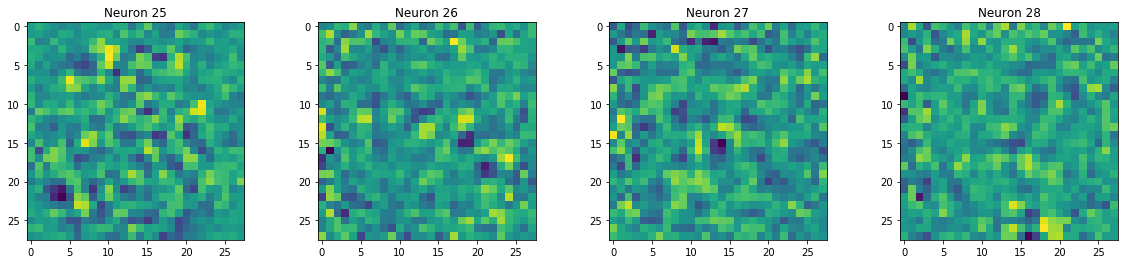

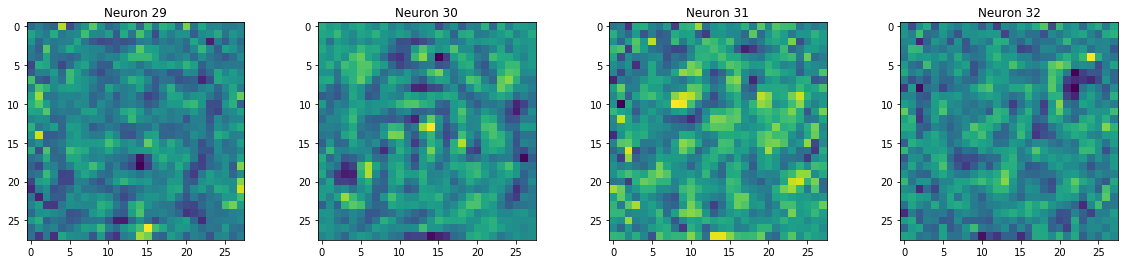

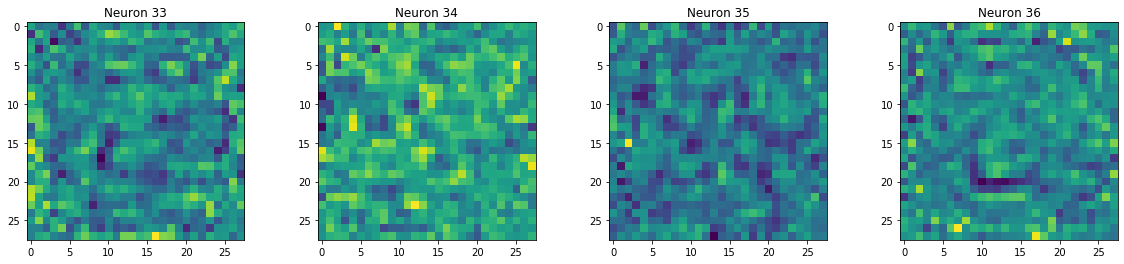

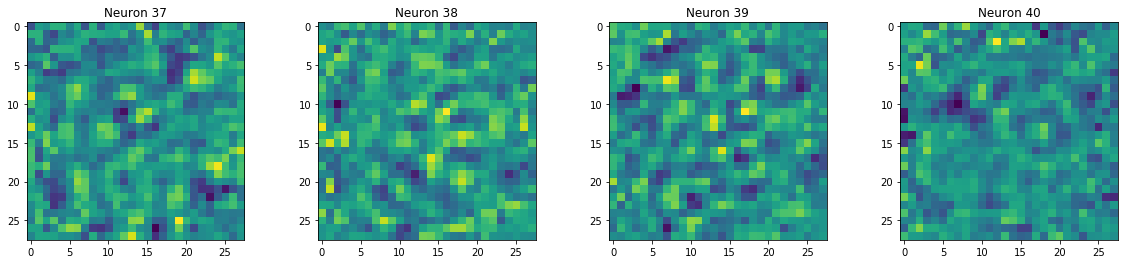

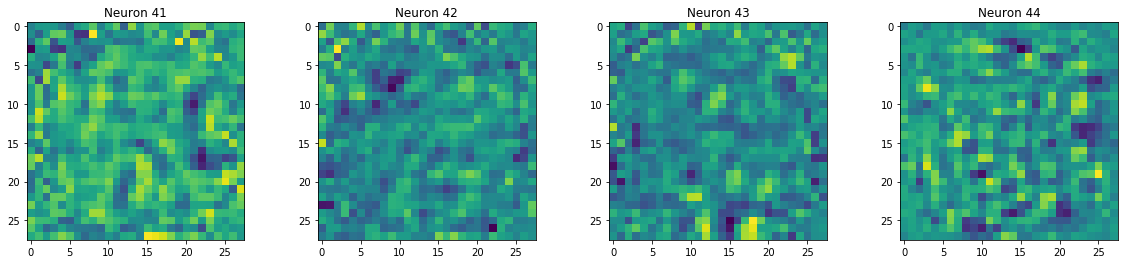

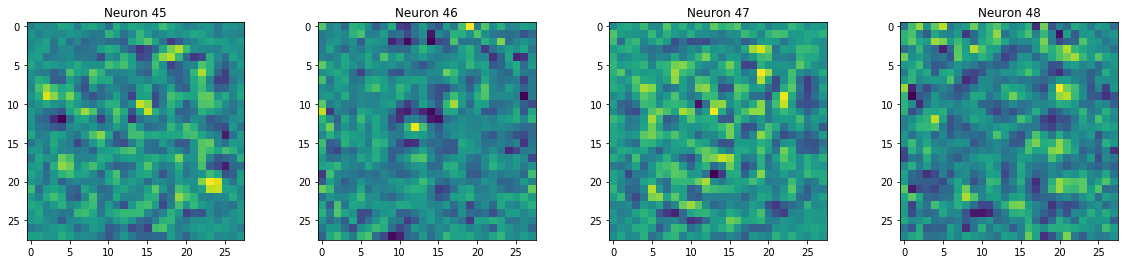

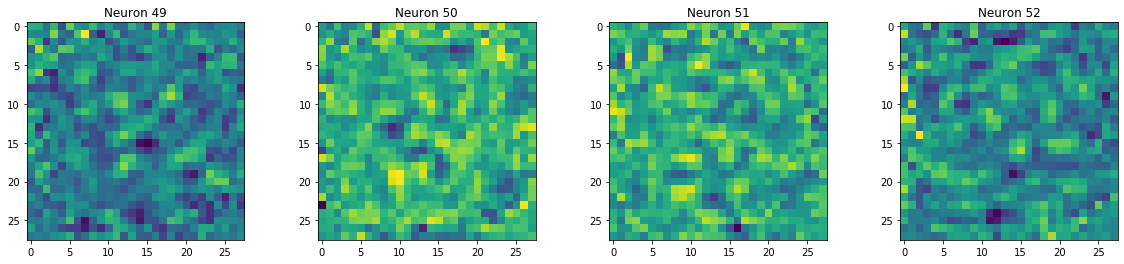

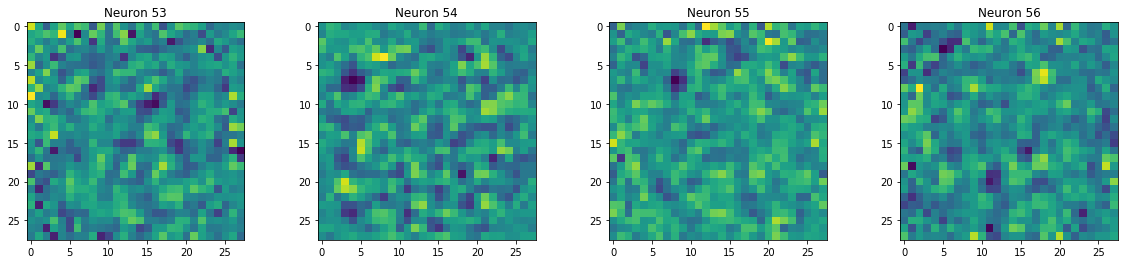

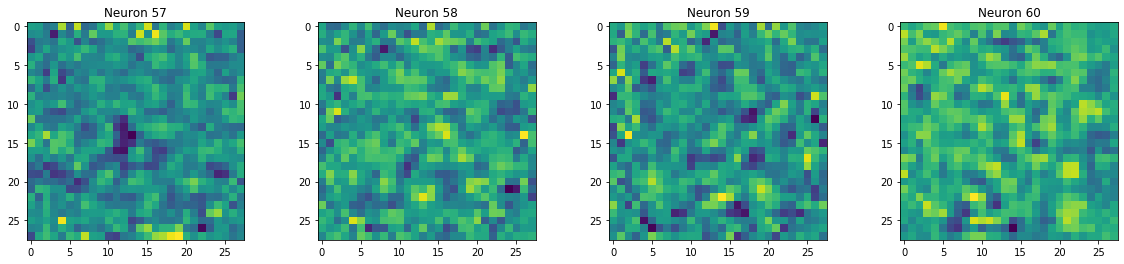

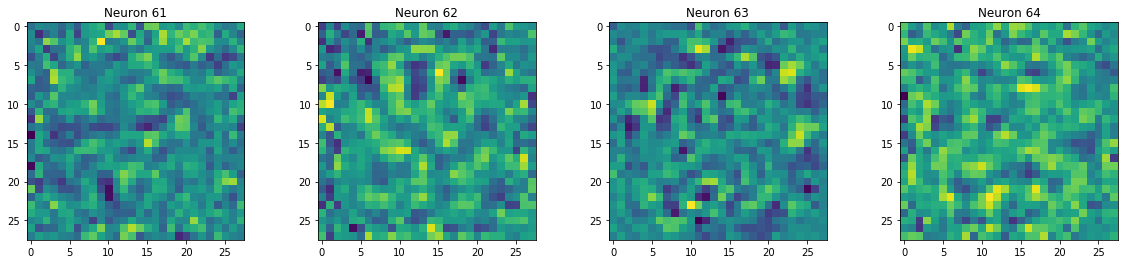

In [154]:
weight_visualization(autoencoder_noise)